In [2]:
%matplotlib inline
from __future__ import division
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
from astropy.table import Table
from scipy.stats import ks_2samp, beta
import math
import mpl_style
import csv
import hex_scatter as hs
#from matplotlib.ticker import MaxNLocator
#import scipy.stats.distributions as dist

H0 = 70.
cosmo = FlatLambdaCDM(H0, Om0=0.3)
h = H0/100

In [3]:
#loading in data from lookup tables

hdulist1 = fits.open('../lookup_redpas_cut.fits') #red and passive galaxies 
redpas_data = hdulist1[1].data
redpas_ind = redpas_data['redpas_ind'] #index of red and passive galaxies in all_data
redpas_pfeatures = redpas_data['redpas_pfeatures'] #the rest are arrays of tuples for the attribute of the type of galaxy
redpas_psmooth = redpas_data['redpas_psmooth'] #the first element of the tuple is the value, and the second is whether its a satellite or central
redpas_color = redpas_data['redpas_color']
redpas_sfr = redpas_data['redpas_sfr']
redpas_mr = redpas_data['redpas_mr']
redpas_mass = redpas_data['redpas_mass']
redpas_galnum = redpas_data['redpas_galnum']

hdulist2 = fits.open('../lookup_redact_cut.fits')
redact_data = hdulist2[1].data
redact_ind = redact_data['redact_ind']
redact_pfeatures = redact_data['redact_pfeatures']
redact_psmooth = redact_data['redact_psmooth']
redact_color = redact_data['redact_color']
redact_sfr = redact_data['redact_sfr']
redact_mr = redact_data['redact_mr']
redact_mass = redact_data['redact_mass']
redact_galnum = redact_data['redact_galnum']

hdulist3 = fits.open('../lookup_bluact_cut.fits')
bluact_data = hdulist3[1].data
bluact_ind = bluact_data['bluact_ind']
bluact_pfeatures = bluact_data['bluact_pfeatures']
bluact_psmooth = bluact_data['bluact_psmooth']
bluact_color = bluact_data['bluact_color']
bluact_sfr = bluact_data['bluact_sfr']
bluact_mr = bluact_data['bluact_mr']
bluact_mass = bluact_data['bluact_mass']
bluact_galnum = bluact_data['bluact_galnum']

hdulist4 = fits.open('../lookup_all_cut.fits')
all_data = hdulist4[1].data
halo_mass = all_data['halo_mass'] #in units of log(Mhalo/(Msun/h))
pfeatures = all_data['pfeatures']
psmooth = all_data['psmooth']
color = all_data['color']
ssfr = all_data['ssfr']
M_r = all_data['M_r']
mass = all_data['mass']
z = all_data['z']
centsat = all_data['centsat']
galaxy_num = all_data['galaxy_num']
group_num = all_data['group_num']

hdulist5 = fits.open('../lookup_spiral_cut.fits')
spiral_data = hdulist5[1].data
spiral_ind = spiral_data['spiral_ind']

hdulist6 = fits.open('../lookup_int_cut.fits')
int_data = hdulist6[1].data
int_ind = int_data['int_ind']

hdulist7 = fits.open('../lookup_smooth_cut.fits')
smooth_data = hdulist7[1].data
smooth_ind = smooth_data['smooth_ind']

group_list = {}
with open('../lookup_group_cut.csv') as f:
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        introw = [int(i) for i in row]
        group_list[introw[0]] = introw[1:]

In [4]:
hdulist1 = fits.open('../lookup_redpas.fits') #same as above but the _all indicates there was no magnitude cut
redpas_data = hdulist1[1].data
redpas_pfeatures_all = redpas_data['redpas_pfeatures']
redpas_color_all = redpas_data['redpas_color']
redpas_sfr_all = redpas_data['redpas_sfr']
redpas_mr_all = redpas_data['redpas_mr']
redpas_mass_all = redpas_data['redpas_mass']

hdulist2 = fits.open('../lookup_redact.fits')
redact_data = hdulist2[1].data
redact_pfeatures_all = redact_data['redact_pfeatures']
redact_color_all = redact_data['redact_color']
redact_sfr_all = redact_data['redact_sfr']
redact_mr_all = redact_data['redact_mr']
redact_mass_all = redact_data['redact_mass']

hdulist3 = fits.open('../lookup_bluact.fits')
bluact_data = hdulist3[1].data
bluact_pfeatures_all = bluact_data['bluact_pfeatures']
bluact_color_all = bluact_data['bluact_color']
bluact_sfr_all = bluact_data['bluact_sfr']
bluact_mr_all = bluact_data['bluact_mr']
bluact_mass_all = bluact_data['bluact_mass']

Above cell gets lists from lookup tables. Note that group_list is a dictionary with the group number as the key and a list of member IDs as the value

In [5]:
#Magnitude limit calculation
z_lim = 0.06
d = cosmo.luminosity_distance(z_lim).to(u.pc)
m = 17 #min brightness we can observe
M_limit = m - 5*math.log(d.value,10) + 5 #absolute magnitude of min brightness we can observe
adj_M_limit = M_limit - 5*math.log(h,10)
print(adj_M_limit) #so we exclude galaxies dimmer than this bc they won't be mass complete

-19.3715154788


In this cell, we use group_list to calculate the average pspiral and ssfr of the satellites of each central

In [6]:
cent_pspiral = []
sat_pspiral_edit = [] #array of pspiral only for groups with centrals
sat_pspiral_all = [] #pspiral of satellites for all groups

cent_ssfr = []
sat_ssfr = []

LG_cent_ssfr_pas_sat = [] #ssfr of central galaxies with N > 2
LG_cent_ssfr_act_sat = [] #same as above but greater than 1/2 star forming fraction
LG_cent_pfeat_smooth_sat = [] #pfeatures of central galaxies with at least 3 satellites with less than 0.2 pfeatures fraction
LG_cent_pfeat_int_sat = []
LG_cent_pfeat_spiral_sat = [] #same as above but greater than 0.8 pfeatures fraction
LG_cent_avg_pfeat_spiral = [] #These three use the average pfeatures of satellites rather than the fraction of type
LG_cent_avg_pfeat_smooth = []
LG_cent_avg_pfeat_int = []

PR_cent_ssfr_pas_sat = [] #ssfr of central galaxies with N = 2 with less than 1/2 star forming fraction (pairs)
PR_cent_ssfr_act_sat = [] #same as above but greater than 1/2 star forming fraction
PR_cent_pfeat_smooth_sat = [] #pfeatures of central galaxies with at least 3 satellites with less than 0.2 pfeatures fraction
PR_cent_pfeat_int_sat = []
PR_cent_pfeat_spiral_sat = [] #same as above but greater than 0.8 pfeatures fraction
PR_cent_avg_pfeat_spiral = [] #These three use the average pfeatures of satellites rather than the fraction of type
PR_cent_avg_pfeat_smooth = []
PR_cent_avg_pfeat_int = []

AG_cent_ssfr_pas_sat = []
AG_cent_ssfr_act_sat = []
AG_cent_pfeat_smooth_sat = []
AG_cent_pfeat_int_sat = []
AG_cent_pfeat_spiral_sat = [] #these are the same as above but for groups of all sizes
AG_cent_avg_pfeat_spiral = [] #These three use the average pfeatures of satellites rather than the fraction of type
AG_cent_avg_pfeat_smooth = []
AG_cent_avg_pfeat_int = []

AG_spiral_cent_ssfr_pas_sat = [] #ssfr of spiral centrals w less than 1/2 sfing fraction of satellites
AG_spiral_cent_ssfr_act_sat = [] #ssfr of spiral centrals w greater than 1/2 sfing fraction of satellites
AG_smooth_cent_ssfr_pas_sat = [] #same for smooth centrals
AG_smooth_cent_ssfr_act_sat = []

AG_LM_cent_ssfr_pas_sat = [] #ssfr of low mass centrals w less than 1/2 sfing fraction of satellites
AG_LM_cent_ssfr_act_sat = [] #ssfr of low mass centrals w greater than 1/2 sfing fraction of satellites
AG_HM_cent_ssfr_pas_sat = [] #same for high mass centrals
AG_HM_cent_ssfr_act_sat = []

AG_active_cent_pfeat_smooth_sat = [] #pfeat of active centrals w less than 1/2 smooth fraction of satellites
AG_active_cent_pfeat_spiral_sat = [] #pfeat of active centrals w greater than 1/2 smooth fraction of satellites
AG_active_cent_pfeat_mixed_sat = [] #same for neither majority of satellites
AG_passive_cent_pfeat_smooth_sat = [] #same for passive centrals
AG_passive_cent_pfeat_spiral_sat = []
AG_passive_cent_pfeat_mixed_sat = []

frac_sat_spiral = []
frac_sat_sfing = []

halo_mass_unlog = np.power(10,halo_mass)
halo_mass_unlog = halo_mass_unlog*h
halo_mass = np.log10(halo_mass_unlog)

for group, group_gals in group_list.iteritems():
    if len(group_gals) > 1: #remove single galaxy groups
        has_central = False
        sat_pfeatures_group = []
        sat_ssfr_group = []
        sat_spiral = 0
        sat_smooth = 0
        sat_sfing = 0
        sat_num = 0
        
        for gal in group_gals: #now loop through these galaxies
            ind = np.where(galaxy_num == gal) #index to use in other arrays for this galaxy
            if centsat[ind[0][0]] == 1: #if its a central galaxy
                cent_ssfr.append(ssfr[ind[0][0]])
                cent_pspiral.append(pfeatures[ind[0][0]])
                cent_mr = M_r[ind[0][0]]
                halo_mass_group = halo_mass[ind[0][0]]
                has_central = True
            else: #satellite galaxy
                sat_num += 1
                sat_pfeatures_group.append(pfeatures[ind[0][0]])
                sat_ssfr_group.append(ssfr[ind[0][0]])
                if pfeatures[ind[0][0]] >= 0.8:
                    sat_spiral += 1
                if pfeatures[ind[0][0]] <= 0.5:
                    sat_smooth += 1
                if ssfr[ind[0][0]] > (-10 + 0.094*(M_r[ind[0][0]] + 15)):
                    sat_sfing += 1
        sat_pspiral_all.append(np.mean(np.array(sat_pfeatures_group)))
        if len(sat_pfeatures_group) < 1:
            print group_gal
        if has_central == True:
            sat_pspiral_edit.append(np.mean(np.array(sat_pfeatures_group)))
            sat_ssfr.append(np.mean(np.array(sat_ssfr_group)))
            
            avg_sat_pfeat = np.sum(sat_pfeatures_group)/sat_num
            
            sf_frac = sat_sfing/sat_num
            spiral_frac = sat_spiral/sat_num
            smooth_frac = sat_smooth/sat_num
            
            frac_sat_spiral.append(spiral_frac)
            frac_sat_sfing.append(sf_frac)
            
            central_pfeat = cent_pspiral[-1]
            central_ssfr = cent_ssfr[-1]
            
            active_line = -10 + 0.094*(cent_mr + 15)
            if central_ssfr >= active_line:
                if spiral_frac >= 0.5:
                    AG_active_cent_pfeat_spiral_sat.append(central_pfeat)
                if smooth_frac >= 0.5:
                    AG_active_cent_pfeat_smooth_sat.append(central_pfeat)
                if spiral_frac < 0.5 and smooth_frac < 0.5:
                    AG_active_cent_pfeat_mixed_sat.append(central_pfeat)
            if central_ssfr < active_line:
                if spiral_frac >= 0.5:
                    AG_passive_cent_pfeat_spiral_sat.append(central_pfeat)
                if smooth_frac >= 0.5:
                    AG_passive_cent_pfeat_smooth_sat.append(central_pfeat)
                if spiral_frac < 0.5 and smooth_frac < 0.5:
                    AG_passive_cent_pfeat_mixed_sat.append(central_pfeat)
            if sf_frac >= 0.5:
                AG_cent_ssfr_act_sat.append(central_ssfr)
                if central_pfeat >= 0.8:
                    AG_spiral_cent_ssfr_act_sat.append(central_ssfr)
                if central_pfeat <= 0.2:
                    AG_smooth_cent_ssfr_act_sat.append(central_ssfr)
                if halo_mass_group <= 12.5:
                    AG_LM_cent_ssfr_act_sat.append(central_ssfr)
                if halo_mass_group > 12.5:
                    AG_HM_cent_ssfr_act_sat.append(central_ssfr)
            if sf_frac < 0.5:
                AG_cent_ssfr_pas_sat.append(central_ssfr)
                if central_pfeat >= 0.8:
                    AG_spiral_cent_ssfr_pas_sat.append(central_ssfr)
                if central_pfeat <= 0.2:
                    AG_smooth_cent_ssfr_pas_sat.append(central_ssfr)
                if halo_mass_group <= 12.5:
                    AG_LM_cent_ssfr_pas_sat.append(central_ssfr)
                if halo_mass_group > 12.5:
                    AG_HM_cent_ssfr_pas_sat.append(central_ssfr)
            if spiral_frac >= 0.5:
                AG_cent_pfeat_spiral_sat.append(central_pfeat)
            if smooth_frac >=0.5:
                AG_cent_pfeat_smooth_sat.append(central_pfeat)
            if spiral_frac < 0.5 and smooth_frac < 0.5:
                AG_cent_pfeat_int_sat.append(central_pfeat)
            if len(sat_pfeatures_group) == 1:
                if sf_frac >= 0.5:
                    PR_cent_ssfr_act_sat.append(central_ssfr)
                if sf_frac < 0.5:
                    PR_cent_ssfr_pas_sat.append(central_ssfr)
                if spiral_frac >= 0.5:
                    PR_cent_pfeat_spiral_sat.append(central_pfeat)
                if smooth_frac >= 0.5:
                    PR_cent_pfeat_smooth_sat.append(central_pfeat)
                if spiral_frac < 0.5 and smooth_frac < 0.5:
                    PR_cent_pfeat_int_sat.append(central_pfeat)
            if len(sat_pfeatures_group) >= 2:
                if sf_frac >= 0.5:
                    LG_cent_ssfr_act_sat.append(central_ssfr)
                if sf_frac < 0.5:
                    LG_cent_ssfr_pas_sat.append(central_ssfr)
                if spiral_frac >= 0.5:
                    LG_cent_pfeat_spiral_sat.append(central_pfeat)
                if smooth_frac >= 0.5:
                    LG_cent_pfeat_smooth_sat.append(central_pfeat)
                if spiral_frac < 0.5 and smooth_frac < 0.5:
                    LG_cent_pfeat_int_sat.append(central_pfeat)

11.461096080028513


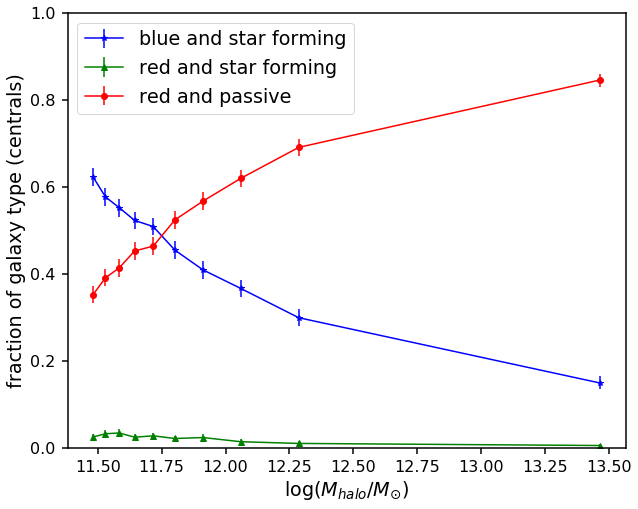

In [30]:
fig = plt.figure(figsize=(10,8))
plt.style.use(mpl_style.style1)

bluact_ind_cent = [x[0] for x in bluact_ind if x[1]==1]
redact_ind_cent = [x[0] for x in redact_ind if x[1]==1]
redpas_ind_cent = [x[0] for x in redpas_ind if x[1]==1]

halo_mass = np.array(halo_mass)
bluact_halo_mass_cent = halo_mass[bluact_ind_cent]
redact_halo_mass_cent = halo_mass[redact_ind_cent]
redpas_halo_mass_cent = halo_mass[redpas_ind_cent]
all_halo_mass_cent = np.concatenate((bluact_halo_mass_cent, redact_halo_mass_cent, redpas_halo_mass_cent))
all_halo_mass_cent = np.sort(all_halo_mass_cent)
i = 0
n = 0
while i <= 0:
    i = all_halo_mass_cent[n]
    n += 1
nonzero_all_halo_mass = all_halo_mass_cent[n-1:]
print np.min(nonzero_all_halo_mass)
    
bin_edges = np.percentile(nonzero_all_halo_mass, np.linspace(0, 100, 11)) #these bins have an equal number of galaxies in each

plotpts = [] #plotpts is the midpoint of each histogram bin
for i in range(len(bin_edges[:-1])):
    plotpts.append(bin_edges[i] + (bin_edges[i+1]-bin_edges[i])/2)

bluact_hist,a_bin = np.histogram(bluact_halo_mass_cent, bin_edges)
redact_hist,b_bin = np.histogram(redact_halo_mass_cent, bin_edges)
redpas_hist,c_bin = np.histogram(redpas_halo_mass_cent, bin_edges)
all_hist = bluact_hist + redact_hist + redpas_hist

bluact_norm_hist = bluact_hist/all_hist
redact_norm_hist = redact_hist/all_hist
redpas_norm_hist = redpas_hist/all_hist

c = 0.95 #confidence level
p_bluact_lower = beta.ppf((1-c)/2.,bluact_hist+1,all_hist-bluact_hist+1)
p_bluact_upper = beta.ppf(1-(1-c)/2.,bluact_hist+1,all_hist-bluact_hist+1)
bluact_yerr = np.array((bluact_norm_hist - p_bluact_lower, p_bluact_upper - bluact_norm_hist))

p_redact_lower = beta.ppf((1-c)/2.,redact_hist+1,all_hist-redact_hist+1)
p_redact_upper = beta.ppf(1-(1-c)/2.,redact_hist+1,all_hist-redact_hist+1)
redact_yerr = np.array((redact_norm_hist - p_redact_lower, p_redact_upper - redact_norm_hist))

p_redpas_lower = beta.ppf((1-c)/2.,redpas_hist+1,all_hist-redpas_hist+1)
p_redpas_upper = beta.ppf(1-(1-c)/2.,redpas_hist+1,all_hist-redpas_hist+1)
redpas_yerr = np.array((redpas_norm_hist - p_redpas_lower, p_redpas_upper - redpas_norm_hist))

plt.errorbar(plotpts, bluact_norm_hist, bluact_yerr, c='b', marker='*', label='blue and star forming')
plt.errorbar(plotpts, redact_norm_hist, redact_yerr, c='g', marker='^', label='red and star forming')
plt.errorbar(plotpts, redpas_norm_hist, redpas_yerr, c='r', marker='o', label='red and passive')
plt.legend()
plt.ylabel('fraction of galaxy type (centrals)')
plt.xlabel(r'$\log (M_{halo}/M_{\odot})$')
#plt.xlim(11.7, 14.9)
plt.ylim(0,1)

plt.show()

11.618598040014257


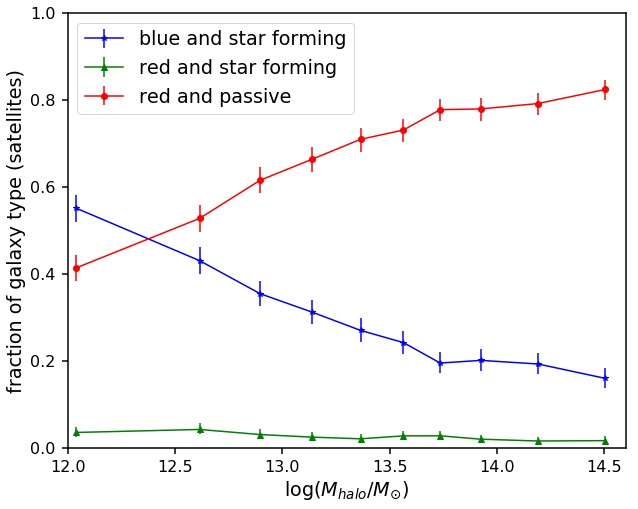

In [7]:
fig = plt.figure(figsize=(10,8))
plt.style.use(mpl_style.style1)

bluact_ind_sat = [x[0] for x in bluact_ind if x[1]==2]
redact_ind_sat = [x[0] for x in redact_ind if x[1]==2]
redpas_ind_sat = [x[0] for x in redpas_ind if x[1]==2]

halo_mass = np.array(halo_mass)
bluact_halo_mass_sat = halo_mass[bluact_ind_sat]
redact_halo_mass_sat = halo_mass[redact_ind_sat]
redpas_halo_mass_sat = halo_mass[redpas_ind_sat]
all_halo_mass_sat = np.concatenate((bluact_halo_mass_sat, redact_halo_mass_sat, redpas_halo_mass_sat))
all_halo_mass_sat = np.sort(all_halo_mass_sat)
i = 0
n = 0
while i <= 0:
    i = all_halo_mass_sat[n]
    n += 1
nonzero_all_halo_mass = all_halo_mass_sat[n-1:]
print np.min(nonzero_all_halo_mass)

bin_edges2 = np.percentile(nonzero_all_halo_mass, np.linspace(0, 100, 11))

bluact_hist2,a_bin2 = np.histogram(bluact_halo_mass_sat, bin_edges2)
redact_hist2,b_bin2 = np.histogram(redact_halo_mass_sat, bin_edges2)
redpas_hist2,c_bin2 = np.histogram(redpas_halo_mass_sat, bin_edges2)
all_hist2 = bluact_hist2 + redact_hist2 + redpas_hist2

plotpts2 = []
for i in range(len(bin_edges2[:-1])):
    plotpts2.append(bin_edges2[i] + (bin_edges2[i+1]-bin_edges2[i])/2)

bluact_norm_hist2 = bluact_hist2/all_hist2
redact_norm_hist2 = redact_hist2/all_hist2
redpas_norm_hist2 = redpas_hist2/all_hist2
    
c = 0.95
p_bluact_lower = beta.ppf((1-c)/2.,bluact_hist2+1,all_hist2-bluact_hist2+1)
p_bluact_upper = beta.ppf(1-(1-c)/2.,bluact_hist2+1,all_hist2-bluact_hist2+1)
bluact_yerr2 =  np.array((bluact_norm_hist2 - p_bluact_lower, p_bluact_upper - bluact_norm_hist2))

p_redact_lower = beta.ppf((1-c)/2.,redact_hist2+1,all_hist2-redact_hist2+1)
p_redact_upper = beta.ppf(1-(1-c)/2.,redact_hist2+1,all_hist2-redact_hist2+1)
redact_yerr2 = np.array((redact_norm_hist2 - p_redact_lower, p_redact_upper - redact_norm_hist2))

p_redpas_lower = beta.ppf((1-c)/2.,redpas_hist2+1,all_hist2-redpas_hist2+1)
p_redpas_upper = beta.ppf(1-(1-c)/2.,redpas_hist2+1,all_hist2-redpas_hist2+1)
redpas_yerr2 = np.array((redpas_norm_hist2 - p_redpas_lower, p_redpas_upper - redpas_norm_hist2))


plt.errorbar(plotpts2, bluact_norm_hist2, bluact_yerr2, c='b', marker='*', label='blue and star forming')
plt.errorbar(plotpts2, redact_norm_hist2, redact_yerr2, c='g', marker='^', label='red and star forming')
plt.errorbar(plotpts2, redpas_norm_hist2, redpas_yerr2, c='r', marker='o', label='red and passive')
plt.legend()
plt.ylabel('fraction of galaxy type (satellites)')
plt.xlabel(r'$\log (M_{halo}/M_{\odot})$')
plt.xlim(12, 14.6)
plt.ylim(0,1)

plt.show()

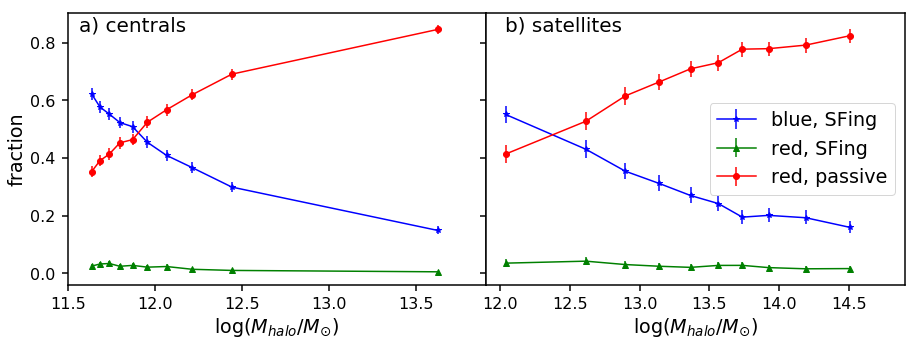

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_figheight(5)
f.set_figwidth(15)

ax1.errorbar(plotpts, bluact_norm_hist, bluact_yerr, c='b', marker='*', label='blue and star forming')
ax1.errorbar(plotpts, redact_norm_hist, redact_yerr, c='g', marker='^', label='red and star forming')
ax1.errorbar(plotpts, redpas_norm_hist, redpas_yerr, c='r', marker='o', label='red and passive')
ax1.set_ylabel('fraction')
ax1.set_xlabel(r'$\log (M_{halo}/M_{\odot})$')
ax1.set_xlim(11.5, 13.9)

ax2.errorbar(plotpts2, bluact_norm_hist2, bluact_yerr2, c='b', marker='*', label='blue, SFing')
ax2.errorbar(plotpts2, redact_norm_hist2, redact_yerr2, c='g', marker='^', label='red, SFing')
ax2.errorbar(plotpts2, redpas_norm_hist2, redpas_yerr2, c='r', marker='o', label='red, passive')
ax2.set_xlabel(r'$\log (M_{halo}/M_{\odot})$')
ax2.set_xlim(11.9, 14.9)

plt.legend()
f.subplots_adjust(wspace=0)

f.text(0.135, 0.83,'a) centrals',fontsize=20)
f.text(0.53, 0.83,'b) satellites',fontsize=20)
plt.savefig('../plots/ssfr_hist_centsat.png',dpi=300)

11.615998040014256


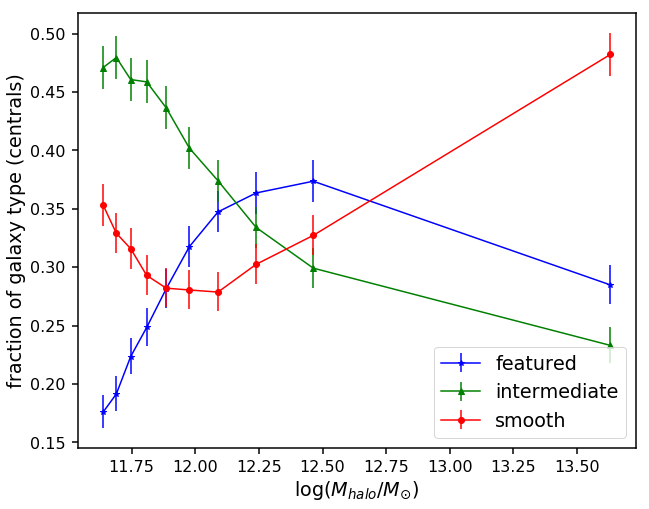

In [9]:
fig = plt.figure(figsize=(10,8))
plt.style.use(mpl_style.style1)

spiral_ind_cent = [x[0] for x in spiral_ind if x[1]==1]
int_ind_cent = [x[0] for x in int_ind if x[1]==1]
smooth_ind_cent = [x[0] for x in smooth_ind if x[1]==1]

halo_mass = np.array(halo_mass)
spiral_halo_mass_cent = halo_mass[spiral_ind_cent]
int_halo_mass_cent = halo_mass[int_ind_cent]
smooth_halo_mass_cent = halo_mass[smooth_ind_cent]
all_halo_mass_cent_mo = np.concatenate((spiral_halo_mass_cent, int_halo_mass_cent, smooth_halo_mass_cent))
all_halo_mass_cent_mo = np.sort(all_halo_mass_cent_mo)
i = 0
n = 0
while i <= 0:
    i = all_halo_mass_cent_mo[n]
    n += 1
nonzero_all_halo_mass_mo = all_halo_mass_cent_mo[n-1:]
print np.min(nonzero_all_halo_mass_mo)

bin_edges_mo = np.percentile(nonzero_all_halo_mass_mo, np.linspace(0, 100, 11))

spiral_hist,a = np.histogram(spiral_halo_mass_cent, bin_edges_mo)
int_hist,b = np.histogram(int_halo_mass_cent, bin_edges_mo)
smooth_hist,c = np.histogram(smooth_halo_mass_cent, bin_edges_mo)
all_hist = spiral_hist + smooth_hist + int_hist

spiral_norm_hist_cent = spiral_hist/all_hist
int_norm_hist_cent = int_hist/all_hist
smooth_norm_hist_cent = smooth_hist/all_hist

c = 0.95
p_spiral_lower = beta.ppf((1-c)/2.,spiral_hist+1,all_hist-spiral_hist+1)
p_spiral_upper = beta.ppf(1-(1-c)/2.,spiral_hist+1,all_hist-spiral_hist+1)
spiral_yerr = np.array((spiral_norm_hist_cent - p_spiral_lower, p_spiral_upper - spiral_norm_hist_cent))

p_int_lower = beta.ppf((1-c)/2.,int_hist+1,all_hist-int_hist+1)
p_int_upper = beta.ppf(1-(1-c)/2.,int_hist+1,all_hist-int_hist+1)
int_yerr = np.array((int_norm_hist_cent - p_int_lower, p_int_upper - int_norm_hist_cent))

p_smooth_lower = beta.ppf((1-c)/2.,smooth_hist+1,all_hist-smooth_hist+1)
p_smooth_upper = beta.ppf(1-(1-c)/2.,smooth_hist+1,all_hist-smooth_hist+1)
smooth_yerr = np.array((smooth_norm_hist_cent - p_smooth_lower, p_smooth_upper - smooth_norm_hist_cent))

plotpts_mo = []
for i in range(len(bin_edges_mo[:-1])):
    plotpts_mo.append(bin_edges_mo[i] + (bin_edges_mo[i+1]-bin_edges_mo[i])/2)

plt.errorbar(plotpts_mo, spiral_norm_hist_cent, spiral_yerr, c='b', marker='*', label='featured')
plt.errorbar(plotpts_mo, int_norm_hist_cent, int_yerr, c='g', marker='^', label='intermediate')
plt.errorbar(plotpts_mo, smooth_norm_hist_cent, smooth_yerr, c='r', marker='o', label='smooth')
#plt.errorbar(bin_edges[1:], spiral_norm_hist_cent, spiral_yerr, c='b', marker='*', label='featured')
#plt.errorbar(bin_edges[1:], int_norm_hist_cent, int_yerr, c='g', marker='^', label='intermediate')
#plt.errorbar(bin_edges[1:], smooth_norm_hist_cent, smooth_yerr, c='r', marker='o', label='smooth')
plt.legend()
plt.ylabel('fraction of galaxy type (centrals)')
plt.xlabel(r'$\log (M_{halo}/M_{\odot})$')
#plt.xlim(12, 15)
#plt.ylim(0,1)

plt.show()

11.618598040014257


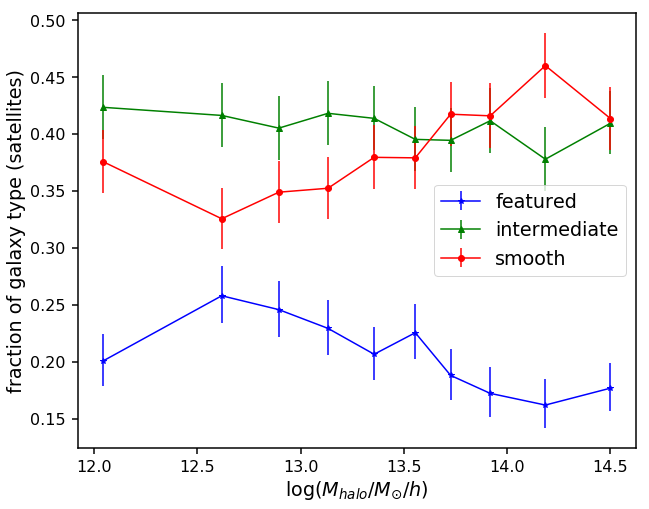

In [10]:
fig = plt.figure(figsize=(10,8))
plt.style.use(mpl_style.style1)

spiral_ind_sat = [x[0] for x in spiral_ind if x[1]==2]
int_ind_sat = [x[0] for x in int_ind if x[1]==2]
smooth_ind_sat = [x[0] for x in smooth_ind if x[1]==2]

halo_mass = np.array(halo_mass)
spiral_halo_mass_sat = halo_mass[spiral_ind_sat]
int_halo_mass_sat = halo_mass[int_ind_sat]
smooth_halo_mass_sat = halo_mass[smooth_ind_sat]
all_halo_mass_cent_mo2 = np.concatenate((spiral_halo_mass_sat, int_halo_mass_sat, smooth_halo_mass_sat))
all_halo_mass_cent_mo2 = np.sort(all_halo_mass_cent_mo2)
i = 0
n = 0
while i <= 0:
    i = all_halo_mass_cent_mo2[n]
    n += 1
nonzero_all_halo_mass_mo2 = all_halo_mass_cent_mo2[n-1:]
print np.min(nonzero_all_halo_mass_mo2)

bin_edges_mo2 = np.percentile(nonzero_all_halo_mass_mo2, np.linspace(0, 100, 11))

spiral_hist,a = np.histogram(spiral_halo_mass_sat, bin_edges_mo2)
int_hist,b = np.histogram(int_halo_mass_sat, bin_edges_mo2)
smooth_hist,bin_edges = np.histogram(smooth_halo_mass_sat, bin_edges_mo2)
all_hist = spiral_hist + smooth_hist + int_hist

spiral_norm_hist = spiral_hist/all_hist
int_norm_hist = int_hist/all_hist
smooth_norm_hist = smooth_hist/all_hist

c = 0.95
p_spiral_lower = beta.ppf((1-c)/2.,spiral_hist+1,all_hist-spiral_hist+1)
p_spiral_upper = beta.ppf(1-(1-c)/2.,spiral_hist+1,all_hist-spiral_hist+1)
spiral_yerr2 = np.array((spiral_norm_hist - p_spiral_lower, p_spiral_upper - spiral_norm_hist))

p_int_lower = beta.ppf((1-c)/2.,int_hist+1,all_hist-int_hist+1)
p_int_upper = beta.ppf(1-(1-c)/2.,int_hist+1,all_hist-int_hist+1)
int_yerr2 = np.array((int_norm_hist - p_int_lower, p_int_upper - int_norm_hist))

p_smooth_lower = beta.ppf((1-c)/2.,smooth_hist+1,all_hist-smooth_hist+1)
p_smooth_upper = beta.ppf(1-(1-c)/2.,smooth_hist+1,all_hist-smooth_hist+1)
smooth_yerr2 = np.array((smooth_norm_hist - p_smooth_lower, p_smooth_upper - smooth_norm_hist))

plotpts_mo2 = []
for i in range(len(bin_edges_mo2[:-1])):
    plotpts_mo2.append(bin_edges_mo2[i] + (bin_edges_mo2[i+1]-bin_edges_mo2[i])/2)

plt.errorbar(plotpts_mo2, spiral_norm_hist, spiral_yerr2, c='b', marker='*', label='featured')
plt.errorbar(plotpts_mo2, int_norm_hist, int_yerr2, c='g', marker='^', label='intermediate')
plt.errorbar(plotpts_mo2, smooth_norm_hist, smooth_yerr2, c='r', marker='o', label='smooth')
plt.legend()
plt.ylabel('fraction of galaxy type (satellites)')
plt.xlabel(r'$\log (M_{halo}/M_{\odot}/h)$')
#plt.xlim(11, 15)
#plt.ylim(0,1)

plt.show()

[333 343 225 226 225 225 225 226]
('low sf num', 1122)
('high sf num', 906)
p value of KS test on high star-forming centrals and low star-forming centrals: 2.661559371743247e-13


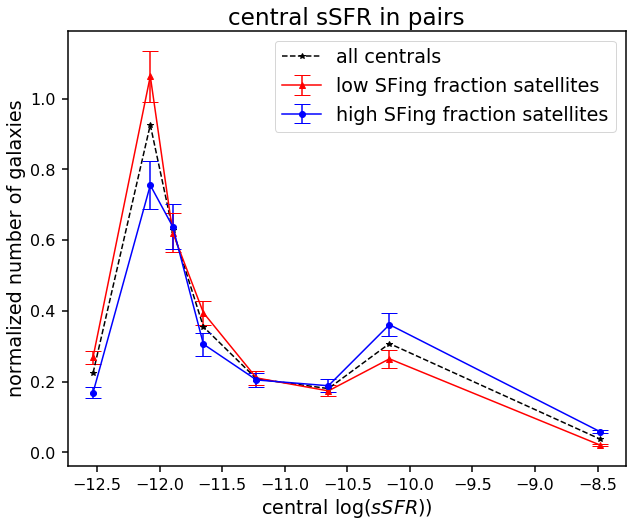

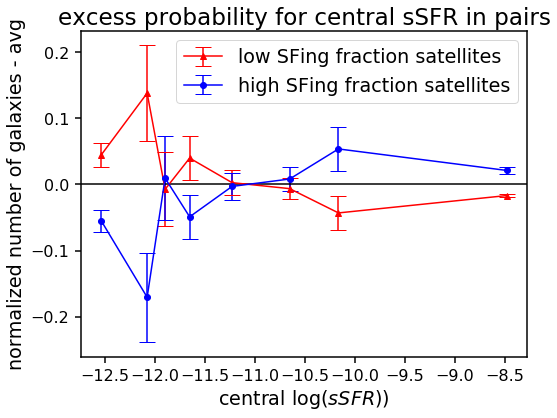

('Low SF central excess probability', 0.11961852869623146)
('high SF central excess probability', 0.14303022179368147)


In [57]:
fig = plt.figure(figsize=(10,8))
plt.style.use(mpl_style.style1)

PR_cent_ssfr = np.concatenate((PR_cent_ssfr_pas_sat, PR_cent_ssfr_act_sat))
    
bin_edges_PR_init = np.percentile(PR_cent_ssfr, np.linspace(0, 100, 10)) #equal sizes in bins

bin_edges_PR = []
combine_inds = [1]
for b in np.arange(len(bin_edges_PR_init)-1):
    if b in combine_inds:
        bin_edges_PR.append((bin_edges_PR_init[b+1] + bin_edges_PR_init[b])/2)
    elif b-1 not in combine_inds:
        bin_edges_PR.append(bin_edges_PR_init[b])
bin_edges_PR.append(bin_edges_PR_init[-1])
        
plotpts_PR = []
for i in range(len(bin_edges_PR[:-1])):
    plotpts_PR.append(bin_edges_PR[i] + (bin_edges_PR[i+1]-bin_edges_PR[i])/2)
plotpts_PR = np.array(plotpts_PR)
cent_ssfr_hist_PR, all_bins_PR = np.histogram(PR_cent_ssfr, density=True, bins=bin_edges_PR)
cent_ssfr_pas_sat_hist_PR, pas_bins_PR= np.histogram(PR_cent_ssfr_pas_sat, density=True, bins=bin_edges_PR)
cent_ssfr_act_sat_hist_PR, act_bins_PR = np.histogram(PR_cent_ssfr_act_sat, density=True, bins=bin_edges_PR)

cent_ssfr_hist_PR_unnorm, all_bins_PR = np.histogram(PR_cent_ssfr, density=False, bins=bin_edges_PR)
cent_ssfr_pas_sat_hist_PR_unnorm, pas_bins_PR= np.histogram(PR_cent_ssfr_pas_sat, density=False, bins=bin_edges_PR)
cent_ssfr_act_sat_hist_PR_unnorm, act_bins_PR = np.histogram(PR_cent_ssfr_act_sat, density=False, bins=bin_edges_PR)
print(cent_ssfr_hist_PR_unnorm)
print('low sf num', len(PR_cent_ssfr_pas_sat))
print('high sf num', len(PR_cent_ssfr_act_sat))
D, p_val = ks_2samp(PR_cent_ssfr_pas_sat, PR_cent_ssfr_act_sat)
print('p value of KS test on high star-forming centrals and low star-forming centrals: '+str(p_val))

#error bars are sqrt(N), then use percent error
pas_yerr_PR_unnorm = np.sqrt(cent_ssfr_pas_sat_hist_PR_unnorm)
pas_yerr_PR = (pas_yerr_PR_unnorm/cent_ssfr_pas_sat_hist_PR_unnorm)*cent_ssfr_pas_sat_hist_PR

act_yerr_PR_unnorm = np.sqrt(cent_ssfr_act_sat_hist_PR_unnorm)
act_yerr_PR = (act_yerr_PR_unnorm/cent_ssfr_act_sat_hist_PR_unnorm)*cent_ssfr_act_sat_hist_PR


plt.errorbar(plotpts_PR, cent_ssfr_pas_sat_hist_PR, pas_yerr_PR, capsize=8, c='r', marker='^', label='low SFing fraction satellites')
plt.plot(plotpts_PR, cent_ssfr_hist_PR, c='k', marker='*', label='all centrals',linestyle='--')
plt.errorbar(plotpts_PR, cent_ssfr_act_sat_hist_PR, act_yerr_PR, capsize=8, c='b', marker='o', label='high SFing fraction satellites')
plt.legend()
plt.title('central sSFR in pairs')
plt.ylabel('normalized number of galaxies')
plt.xlabel('central '+r'$\log (sSFR))$')
#plt.xlim(-13, -9)
plt.show()

plt.errorbar(plotpts_PR, cent_ssfr_pas_sat_hist_PR - cent_ssfr_hist_PR, pas_yerr_PR, capsize=8, c='r', marker='^', label='low SFing fraction satellites')
plt.errorbar(plotpts_PR, cent_ssfr_act_sat_hist_PR - cent_ssfr_hist_PR, act_yerr_PR, capsize=8, c='b', marker='o', label='high SFing fraction satellites')
plt.legend()
plt.axhline(0, c='k')
plt.title('excess probability for central sSFR in pairs')
plt.ylabel('normalized number of galaxies - avg')
plt.xlabel('central '+r'$\log (sSFR))$')
#plt.xlim(-13, -9)
plt.show()

low_sfr_bins = plotpts_PR[:3]
low_sfr_act = cent_ssfr_act_sat_hist_PR[:3]
low_sfr_pas = cent_ssfr_pas_sat_hist_PR[:3]
excess_low = np.abs(np.trapz(low_sfr_act, low_sfr_bins) - np.trapz(low_sfr_pas, low_sfr_bins))
print('Low SF central excess probability', excess_low)

high_sfr_bins = plotpts_PR[-4:]
high_sfr_act= cent_ssfr_act_sat_hist_PR[-4:]
high_sfr_pas = cent_ssfr_pas_sat_hist_PR[-4:]
excess_high = np.abs(np.trapz(high_sfr_act, high_sfr_bins) - np.trapz(high_sfr_pas, high_sfr_bins))
print('high SF central excess probability', excess_high)



('low sf num', 853)
('high sf num', 424)
p value of KS test on high star-forming centrals and low star-forming centrals: 3.4321503579172056e-15


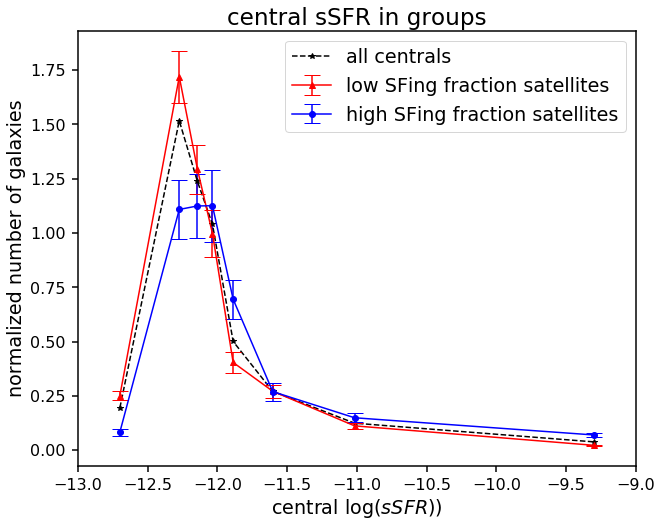

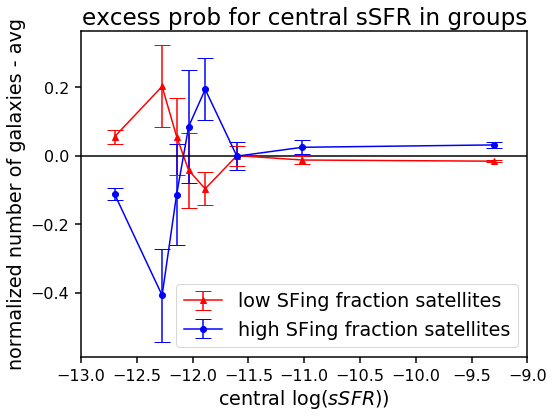

('Low SF central excess probability', 0.21659426017277666)
('high SF central excess probability', 0.12443199839657276)


In [64]:
fig = plt.figure(figsize=(10,8))
plt.style.use(mpl_style.style1)

LG_cent_ssfr = np.concatenate((LG_cent_ssfr_pas_sat, LG_cent_ssfr_act_sat))    
bin_edges_LG_init = np.percentile(LG_cent_ssfr, np.linspace(0, 100, 11))

bin_edges_LG = []
combine_inds = [1,3]
for b in np.arange(len(bin_edges_LG_init)-1):
    if b in combine_inds:
        bin_edges_LG.append((bin_edges_LG_init[b+1] + bin_edges_LG_init[b])/2)
    elif b-1 not in combine_inds:
        bin_edges_LG.append(bin_edges_LG_init[b])
bin_edges_LG.append(bin_edges_LG_init[-1])

plotpts_LG = []
for i in range(len(bin_edges_LG[:-1])):
    plotpts_LG.append(bin_edges_LG[i] + (bin_edges_LG[i+1]-bin_edges_LG[i])/2)
plotpts_LG = np.array(plotpts_LG)
cent_ssfr_hist_LG, all_bins_LG = np.histogram(LG_cent_ssfr, density=True, bins=bin_edges_LG)
cent_ssfr_pas_sat_hist_LG, pas_bins_LG = np.histogram(LG_cent_ssfr_pas_sat, density=True, bins=bin_edges_LG)
cent_ssfr_act_sat_hist_LG, act_bins_LG = np.histogram(LG_cent_ssfr_act_sat, density=True, bins = bin_edges_LG)
print('low sf num', len(LG_cent_ssfr_pas_sat))
print('high sf num', len(LG_cent_ssfr_act_sat))
D, p_val = ks_2samp(LG_cent_ssfr_pas_sat, LG_cent_ssfr_act_sat)
print('p value of KS test on high star-forming centrals and low star-forming centrals: '+str(p_val))

cent_ssfr_hist_LG_unnorm, all_bins_LG = np.histogram(LG_cent_ssfr, density=False, bins=bin_edges_LG)
cent_ssfr_pas_sat_hist_LG_unnorm, pas_bins_LG = np.histogram(LG_cent_ssfr_pas_sat, density=False, bins=bin_edges_LG)
cent_ssfr_act_sat_hist_LG_unnorm, act_bins_LG = np.histogram(LG_cent_ssfr_act_sat, density=False, bins = bin_edges_LG)

pas_yerr_LG_unnorm = np.sqrt(cent_ssfr_pas_sat_hist_LG_unnorm)
pas_yerr_LG = (pas_yerr_LG_unnorm/cent_ssfr_pas_sat_hist_LG_unnorm)*cent_ssfr_pas_sat_hist_LG

act_yerr_LG_unnorm = np.sqrt(cent_ssfr_act_sat_hist_LG_unnorm)
act_yerr_LG = (act_yerr_LG_unnorm/cent_ssfr_act_sat_hist_LG_unnorm)*cent_ssfr_act_sat_hist_LG

plt.plot(plotpts_LG, cent_ssfr_hist_LG, c='k', marker='*', label='all centrals',linestyle='--')
plt.errorbar(plotpts_LG, cent_ssfr_pas_sat_hist_LG, pas_yerr_LG, capsize=8, c='r', marker='^', label='low SFing fraction satellites')
plt.errorbar(plotpts_LG, cent_ssfr_act_sat_hist_LG, act_yerr_LG, capsize=8, c='b', marker='o', label='high SFing fraction satellites')
plt.legend()
plt.title('central sSFR in groups')
plt.ylabel('normalized number of galaxies')
plt.xlabel('central '+r'$\log (sSFR))$')
plt.xlim(-13, -9)
plt.show()

plt.axhline(0, c='k')
plt.errorbar(plotpts_LG, cent_ssfr_pas_sat_hist_LG - cent_ssfr_hist_LG, pas_yerr_LG, capsize=8, c='r', marker='^', label='low SFing fraction satellites')
plt.errorbar(plotpts_LG, cent_ssfr_act_sat_hist_LG - cent_ssfr_hist_LG, act_yerr_LG, capsize=8, c='b', marker='o', label='high SFing fraction satellites')
plt.legend()
plt.title('excess prob for central sSFR in groups')
plt.ylabel('normalized number of galaxies - avg')
plt.xlabel('central '+r'$\log (sSFR))$')
plt.xlim(-13, -9)
plt.show()

bins = plotpts_LG
low_sfr_bins = bins[:3]
low_sfr_act = cent_ssfr_act_sat_hist_LG[:3]
low_sfr_pas = cent_ssfr_pas_sat_hist_LG[:3]
excess_low = np.abs(np.trapz(low_sfr_act, low_sfr_bins) - np.trapz(low_sfr_pas, low_sfr_bins))
print('Low SF central excess probability', excess_low)

high_sfr_bins = bins[-4:]
high_sfr_act= cent_ssfr_act_sat_hist_LG[-4:]
high_sfr_pas = cent_ssfr_pas_sat_hist_LG[-4:]
excess_high = np.abs(np.trapz(high_sfr_act, high_sfr_bins) - np.trapz(high_sfr_pas, high_sfr_bins))
print('high SF central excess probability', excess_high)

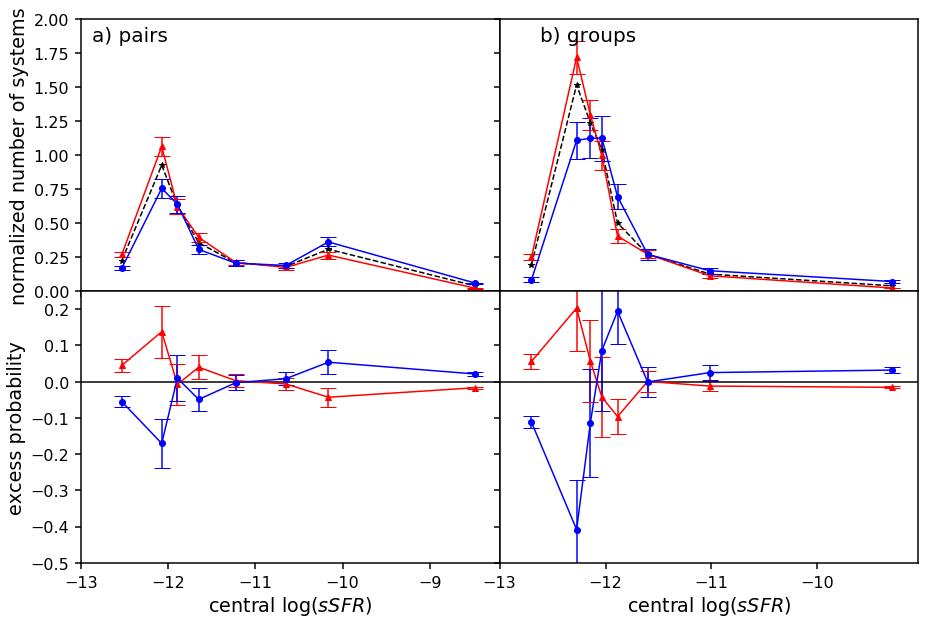

In [71]:
f, ((ax1, ax2), (ax4, ax5)) = plt.subplots(2, 2, sharex='col', sharey='row')
f.set_figheight(10)
f.set_figwidth(15)

ax1.plot(plotpts_PR, cent_ssfr_hist_PR, c='k', marker='*', label='all centrals',linestyle='--')
ax1.errorbar(plotpts_PR, cent_ssfr_pas_sat_hist_PR, pas_yerr_PR, capsize=8, c='r', marker='^', label='low SFing fraction satellites')
ax1.errorbar(plotpts_PR, cent_ssfr_act_sat_hist_PR, act_yerr_PR, capsize=8, c='b', marker='o', label='high SFing fraction satellites')
ax1.set_ylabel('normalized number of systems')
#ax1.set_xlabel('central '+r'$\log(sSFR)$')
ax1.set_ylim(0, 2)
ax1.set_xlim(-13, -8.2)
start, end = ax1.get_xlim()
ax1.xaxis.set_ticks(np.arange(start, end, 1))

ax2.plot(plotpts_LG, cent_ssfr_hist_LG, c='k', marker='*', label='all',linestyle='--')
ax2.errorbar(plotpts_LG, cent_ssfr_pas_sat_hist_LG, pas_yerr_LG, capsize=8, c='r', marker='^', label='low SF')
ax2.errorbar(plotpts_LG, cent_ssfr_act_sat_hist_LG, act_yerr_LG, capsize=8, c='b', marker='o', label='high SF')
ax2.set_xlim(-13, -9.05)
#ax2.set_ylim(0, 1.4)
#ax2.set_xlabel('central '+r'$\log (sSFR))$')
start, end = ax2.get_xlim()
ax2.xaxis.set_ticks(np.arange(start, end, 1))

ax4.errorbar(plotpts_PR, cent_ssfr_pas_sat_hist_PR - cent_ssfr_hist_PR, pas_yerr_PR, capsize=8, c='r', marker='^', label='low SFing fraction satellites')
ax4.errorbar(plotpts_PR, cent_ssfr_act_sat_hist_PR - cent_ssfr_hist_PR, act_yerr_PR, capsize=8, c='b', marker='o', label='high SFing fraction satellites')
ax4.set_ylabel('excess probability')
ax4.set_xlabel('central '+r'$\log(sSFR)$')
ax4.axhline(0, c='k')
ax4.set_ylim(-0.5, 0.25)

ax5.errorbar(plotpts_LG, cent_ssfr_pas_sat_hist_LG - cent_ssfr_hist_LG, pas_yerr_LG, capsize=8, c='r', marker='^', label='low SFing fraction satellites')
ax5.errorbar(plotpts_LG, cent_ssfr_act_sat_hist_LG - cent_ssfr_hist_LG, act_yerr_LG, capsize=8, c='b', marker='o', label='high SFing fraction satellites')
ax5.set_xlabel('central '+r'$\log(sSFR)$')
ax5.axhline(0, c='k')
#ax5.set_ylim(-0.3, 0.3)


f.subplots_adjust(wspace=0)
f.subplots_adjust(hspace=0)

f.text(0.135, 0.85,'a) pairs',fontsize=20)
f.text(0.55, 0.85,r'b) groups',fontsize=20)
plt.savefig('../plots/ssfr_hist.png',dpi=300)

('low sf', 462)
('high sf', 416)
p value of KS test on high star-forming satellite centrals, low star-forming satellite centrals: 6.506705548869837e-10


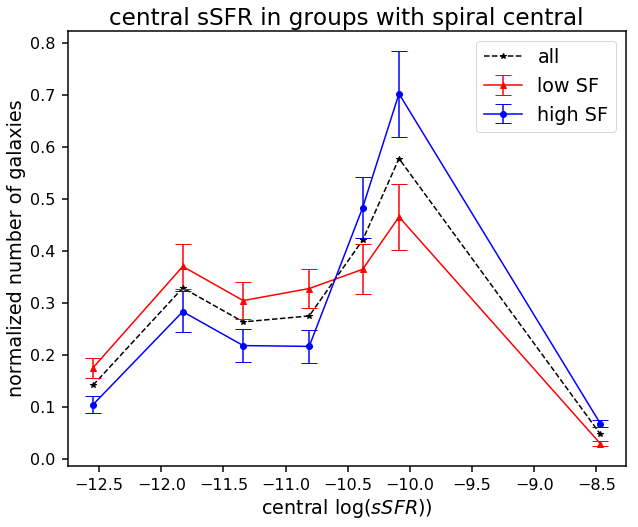

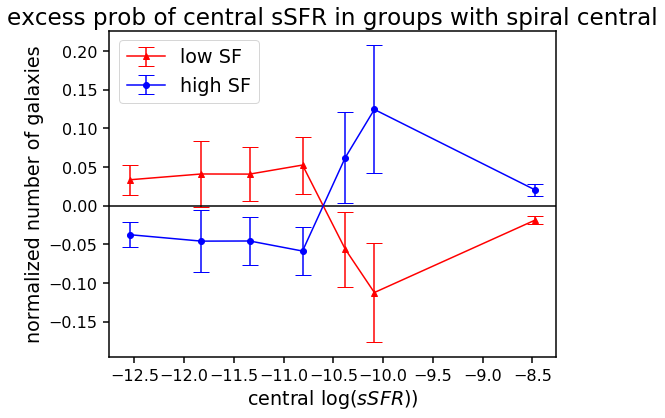

('Low SF central excess probability', 0.09909278985406866)
('high SF central excess probability', 0.27653102370121196)


In [75]:
fig = plt.figure(figsize=(10,8))
plt.style.use(mpl_style.style1)

AG_spiral_cent_ssfr = np.concatenate((AG_spiral_cent_ssfr_pas_sat, AG_spiral_cent_ssfr_act_sat))

bin_edges_spiral = np.percentile(AG_spiral_cent_ssfr, np.linspace(0, 100, 8))
plotpts_spiral = []
for i in range(len(bin_edges_spiral[:-1])):
    plotpts_spiral.append(bin_edges_spiral[i] + (bin_edges_spiral[i+1]-bin_edges_spiral[i])/2)
plotpts_spiral = np.array(plotpts_spiral)
print('low sf', len(AG_spiral_cent_ssfr_pas_sat))
print('high sf', len(AG_spiral_cent_ssfr_act_sat))

cent_spiral_ssfr_hist, all_bins = np.histogram(AG_spiral_cent_ssfr, density=True, bins=bin_edges_spiral)
cent_spiral_ssfr_pas_sat_hist,pas_bins = np.histogram(AG_spiral_cent_ssfr_pas_sat, density=True, bins=bin_edges_spiral)
cent_spiral_ssfr_act_sat_hist,act_bins = np.histogram(AG_spiral_cent_ssfr_act_sat, density=True, bins=bin_edges_spiral)

cent_spiral_ssfr_hist_unnorm, all_bins = np.histogram(AG_spiral_cent_ssfr, density=False, bins=bin_edges_spiral)
cent_spiral_ssfr_pas_sat_hist_unnorm,pas_bins = np.histogram(AG_spiral_cent_ssfr_pas_sat, density=False, bins=bin_edges_spiral)
cent_spiral_ssfr_act_sat_hist_unnorm,act_bins = np.histogram(AG_spiral_cent_ssfr_act_sat, density=False, bins=bin_edges_spiral)

D, p_val = ks_2samp(AG_spiral_cent_ssfr_pas_sat, AG_spiral_cent_ssfr_act_sat)
print('p value of KS test on high star-forming satellite centrals, low star-forming satellite centrals: '+str(p_val))

spiral_cent_pas_yerr_unnorm = np.sqrt(cent_spiral_ssfr_pas_sat_hist_unnorm)
spiral_cent_pas_yerr = (spiral_cent_pas_yerr_unnorm/cent_spiral_ssfr_pas_sat_hist_unnorm)*cent_spiral_ssfr_pas_sat_hist

spiral_cent_act_yerr_unnorm = np.sqrt(cent_spiral_ssfr_act_sat_hist_unnorm)
spiral_cent_act_yerr = (spiral_cent_act_yerr_unnorm/cent_spiral_ssfr_act_sat_hist_unnorm)*cent_spiral_ssfr_act_sat_hist

plt.plot(plotpts_spiral, cent_spiral_ssfr_hist, c='k', marker='*', label='all',linestyle='--')
plt.errorbar(plotpts_spiral, cent_spiral_ssfr_pas_sat_hist, spiral_cent_pas_yerr, capsize=8, c='r', marker='^', label='low SF')
plt.errorbar(plotpts_spiral, cent_spiral_ssfr_act_sat_hist, spiral_cent_act_yerr, capsize=8, c='b', marker='o', label='high SF')
plt.legend()
plt.title('central sSFR in groups with spiral central')
plt.ylabel('normalized number of galaxies')
plt.xlabel('central '+r'$\log (sSFR))$')
#plt.xlim(12.5, 15)
plt.show()

plt.errorbar(plotpts_spiral, cent_spiral_ssfr_pas_sat_hist - cent_spiral_ssfr_hist, spiral_cent_pas_yerr, capsize=8, c='r', marker='^', label='low SF')
plt.errorbar(plotpts_spiral, cent_spiral_ssfr_act_sat_hist - cent_spiral_ssfr_hist, spiral_cent_act_yerr, capsize=8, c='b', marker='o', label='high SF')
plt.legend()
plt.title('excess prob of central sSFR in groups with spiral central')
plt.ylabel('normalized number of galaxies')
plt.xlabel('central '+r'$\log (sSFR))$')
#plt.xlim(-13, -9)
plt.axhline(0,c='k')
plt.show()

bins = plotpts_spiral
low_sfr_bins = bins[:3]
low_sfr_act = cent_spiral_ssfr_act_sat_hist[:3]
low_sfr_pas = cent_spiral_ssfr_pas_sat_hist[:3]
excess_low = np.abs(np.trapz(low_sfr_act, low_sfr_bins) - np.trapz(low_sfr_pas, low_sfr_bins))
print('Low SF central excess probability', excess_low)

high_sfr_bins = bins[-4:]
high_sfr_act= cent_spiral_ssfr_act_sat_hist[-4:]
high_sfr_pas = cent_spiral_ssfr_pas_sat_hist[-4:]
excess_high = np.abs(np.trapz(high_sfr_act, high_sfr_bins) - np.trapz(high_sfr_pas, high_sfr_bins))
print('high SF central excess probability', excess_high)

('low sf', 1022)
('high sf', 514)
p value of KS test on high star-forming satellite centrals, low star-forming satellite centrals: 1.5352459156039883e-13


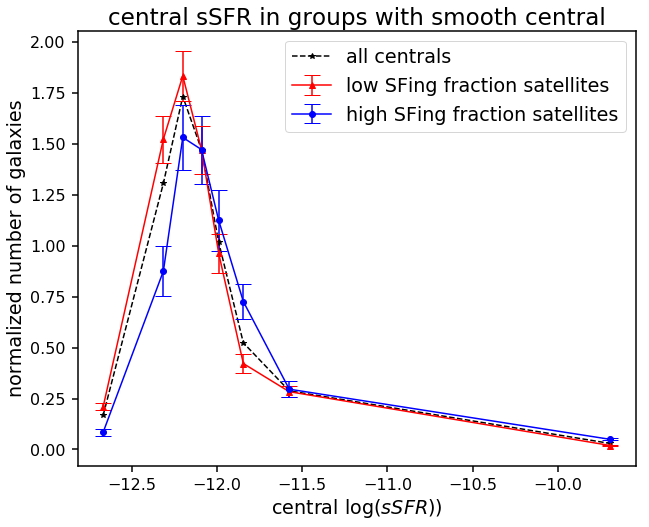

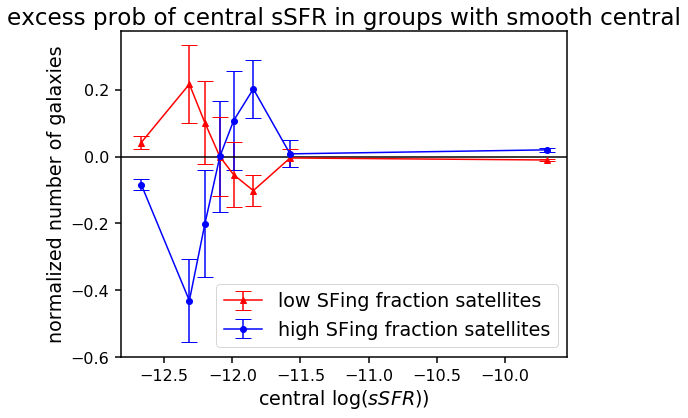

('Low SF central excess probability', 0.1906172923234321)
('high SF central excess probability', 0.11648505967574829)


In [78]:
fig = plt.figure(figsize=(10,8))
plt.style.use(mpl_style.style1)

AG_smooth_cent_ssfr = np.concatenate((AG_smooth_cent_ssfr_pas_sat, AG_smooth_cent_ssfr_act_sat))
bin_edges_smooth_init = np.percentile(AG_smooth_cent_ssfr, np.linspace(0, 100, 11))

bin_edges_smooth = []
combine_inds = [2,4]
for b in np.arange(len(bin_edges_smooth_init)-1):
    if b in combine_inds:
        bin_edges_smooth.append((bin_edges_smooth_init[b+1] + bin_edges_smooth_init[b])/2)
    elif b-1 not in combine_inds:
        bin_edges_smooth.append(bin_edges_smooth_init[b])
bin_edges_smooth.append(bin_edges_smooth_init[-1])


plotpts_smooth = []
for i in range(len(bin_edges_smooth[:-1])):
    plotpts_smooth.append(bin_edges_smooth[i] + (bin_edges_smooth[i+1]-bin_edges_smooth[i])/2)
plotpts_smooth = np.array(plotpts_smooth)
print('low sf', len(AG_smooth_cent_ssfr_pas_sat))
print('high sf', len(AG_smooth_cent_ssfr_act_sat))

cent_smooth_ssfr_hist, all_bins2 = np.histogram(AG_smooth_cent_ssfr, density=True, bins=bin_edges_smooth)
cent_smooth_ssfr_pas_sat_hist, pas_bins2 = np.histogram(AG_smooth_cent_ssfr_pas_sat, density=True, bins=bin_edges_smooth)
cent_smooth_ssfr_act_sat_hist, act_bins2 = np.histogram(AG_smooth_cent_ssfr_act_sat, density=True, bins=bin_edges_smooth)

cent_smooth_ssfr_hist_unnorm, all_bins2 = np.histogram(AG_smooth_cent_ssfr, density=False, bins=bin_edges_smooth)
cent_smooth_ssfr_pas_sat_hist_unnorm, pas_bins2 = np.histogram(AG_smooth_cent_ssfr_pas_sat, density=False, bins=bin_edges_smooth)
cent_smooth_ssfr_act_sat_hist_unnorm, act_bins2 = np.histogram(AG_smooth_cent_ssfr_act_sat, density=False, bins=bin_edges_smooth)

D, p_val = ks_2samp(AG_smooth_cent_ssfr_pas_sat, AG_smooth_cent_ssfr_act_sat)
print('p value of KS test on high star-forming satellite centrals, low star-forming satellite centrals: '+str(p_val))

smooth_cent_pas_yerr_unnorm = np.sqrt(cent_smooth_ssfr_pas_sat_hist_unnorm)
smooth_cent_pas_yerr = (smooth_cent_pas_yerr_unnorm/cent_smooth_ssfr_pas_sat_hist_unnorm)*cent_smooth_ssfr_pas_sat_hist

smooth_cent_act_yerr_unnorm = np.sqrt(cent_smooth_ssfr_act_sat_hist_unnorm)
smooth_cent_act_yerr = (smooth_cent_act_yerr_unnorm/cent_smooth_ssfr_act_sat_hist_unnorm)*cent_smooth_ssfr_act_sat_hist

plt.plot(plotpts_smooth, cent_smooth_ssfr_hist, c='k', marker='*', label='all centrals',linestyle='--')
plt.errorbar(plotpts_smooth, cent_smooth_ssfr_pas_sat_hist, smooth_cent_pas_yerr, capsize=8, c='r', marker='^', label='low SFing fraction satellites')
plt.errorbar(plotpts_smooth, cent_smooth_ssfr_act_sat_hist, smooth_cent_act_yerr, capsize=8, c='b', marker='o', label='high SFing fraction satellites')
plt.legend()
plt.title('central sSFR in groups with smooth central')
plt.ylabel('normalized number of galaxies')
plt.xlabel('central '+r'$\log (sSFR))$')
#plt.xlim(12.5, 15)
plt.show()

plt.errorbar(plotpts_smooth, cent_smooth_ssfr_pas_sat_hist - cent_smooth_ssfr_hist, smooth_cent_pas_yerr, capsize=8, c='r', marker='^', label='low SFing fraction satellites')
plt.errorbar(plotpts_smooth, cent_smooth_ssfr_act_sat_hist - cent_smooth_ssfr_hist, smooth_cent_act_yerr, capsize=8, c='b', marker='o', label='high SFing fraction satellites')
plt.legend()
plt.title('excess prob of central sSFR in groups with smooth central')
plt.ylabel('normalized number of galaxies')
plt.xlabel('central '+r'$\log (sSFR))$')
plt.axhline(0,c='k')
plt.show()

bins = plotpts_smooth
low_sfr_bins = bins[:3]
low_sfr_act = cent_smooth_ssfr_act_sat_hist[:3]
low_sfr_pas = cent_smooth_ssfr_pas_sat_hist[:3]
excess_low = np.abs(np.trapz(low_sfr_act, low_sfr_bins) - np.trapz(low_sfr_pas, low_sfr_bins))
print('Low SF central excess probability', excess_low)

high_sfr_bins = bins[-4:]
high_sfr_act= cent_smooth_ssfr_act_sat_hist[-4:]
high_sfr_pas = cent_smooth_ssfr_pas_sat_hist[-4:]
excess_high = np.abs(np.trapz(high_sfr_act, high_sfr_bins) - np.trapz(high_sfr_pas, high_sfr_bins))
print('high SF central excess probability', excess_high)

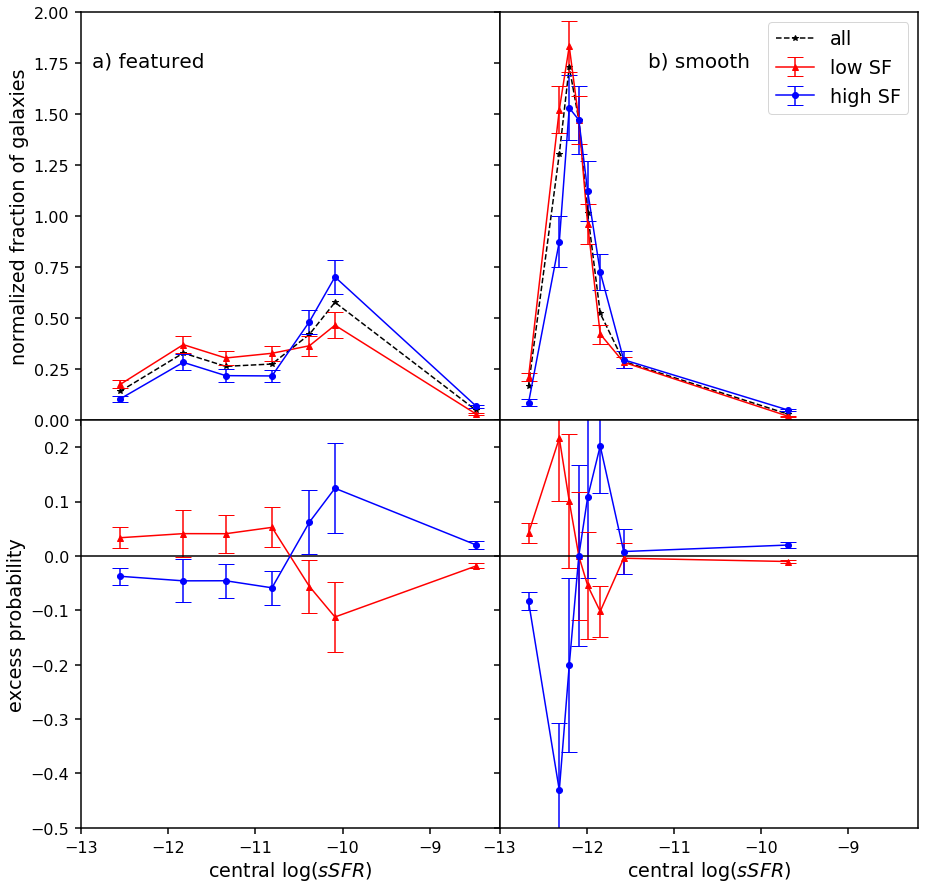

In [108]:
f, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2, sharey='row', sharex='col')
f.set_figheight(15)
f.set_figwidth(15)

ax1.plot(plotpts_spiral, cent_spiral_ssfr_hist, c='k', marker='*', label='all centrals',linestyle='--')
ax1.errorbar(plotpts_spiral, cent_spiral_ssfr_pas_sat_hist, spiral_cent_pas_yerr, capsize=8, c='r', marker='^', label='low SFing fraction satellites')
ax1.errorbar(plotpts_spiral, cent_spiral_ssfr_act_sat_hist, spiral_cent_act_yerr, capsize=8, c='b', marker='o', label='high SFing fraction satellites')
#ax1.legend()
ax1.set_ylabel('normalized fraction of galaxies')
#ax1.set_xlabel('central '+r'$\log(sSFR)$')
ax1.set_ylim(0, 2)
ax1.set_xlim(-13, -8.2)

ax2.plot(plotpts_smooth, cent_smooth_ssfr_hist, c='k', marker='*', label='all',linestyle='--')
ax2.errorbar(plotpts_smooth, cent_smooth_ssfr_pas_sat_hist, smooth_cent_pas_yerr, capsize=8, c='r', marker='^', label='low SF')
ax2.errorbar(plotpts_smooth, cent_smooth_ssfr_act_sat_hist, smooth_cent_act_yerr, capsize=8, c='b', marker='o', label='high SF')
#ax2.set_ylabel('fraction')
ax2.set_xlim(-13, -8.2)
ax2.legend()
#ax2.set_xlabel('central '+r'$\log (sSFR))$')

ax3.errorbar(plotpts_spiral, cent_spiral_ssfr_pas_sat_hist - cent_spiral_ssfr_hist, spiral_cent_pas_yerr, capsize=8, c='r', marker='^', label='low SFing fraction satellites')
ax3.errorbar(plotpts_spiral, cent_spiral_ssfr_act_sat_hist - cent_spiral_ssfr_hist, spiral_cent_act_yerr, capsize=8, c='b', marker='o', label='high SFing fraction satellites')
ax3.set_ylabel('excess probability')
ax3.set_xlabel('central '+r'$\log(sSFR)$')
ax3.axhline(0, c='k')
ax3.set_ylim(-.5, .25)

ax4.errorbar(plotpts_smooth, cent_smooth_ssfr_pas_sat_hist - cent_smooth_ssfr_hist, smooth_cent_pas_yerr, capsize=8, c='r', marker='^', label='low SFing fraction satellites')
ax4.errorbar(plotpts_smooth, cent_smooth_ssfr_act_sat_hist - cent_smooth_ssfr_hist, smooth_cent_act_yerr, capsize=8, c='b', marker='o', label='high SFing fraction satellites')
ax4.set_xlabel('central '+r'$\log(sSFR)$')
ax4.axhline(0, c='k')

f.subplots_adjust(wspace=0, hspace=0)

f.text(0.135, 0.83,'a) featured',fontsize=20)
f.text(0.65, 0.83,'b) smooth',fontsize=20)
plt.savefig('../plots/ssfr_hist_morphology.png',dpi=300)

('low sf', 469)
('high sf', 547)
p value of KS test on high star-forming satellite centrals, low star-forming satellite centrals: 2.1480641847027277e-06


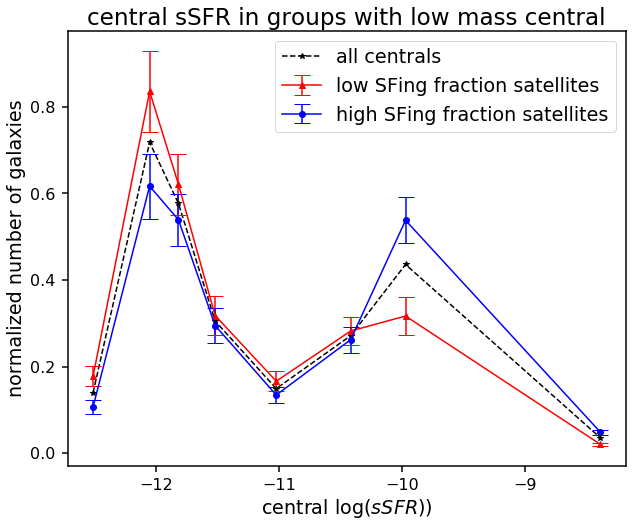

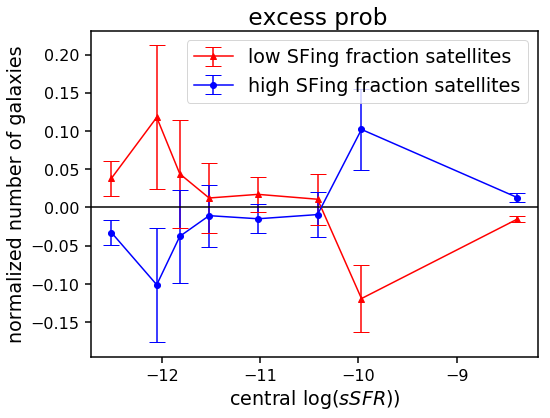

('Low SF central excess probability', 0.10205459012441298)
('high SF central excess probability', 0.22694063775544204)


In [86]:
fig = plt.figure(figsize=(10,8))
plt.style.use(mpl_style.style1)

AG_LM_cent_ssfr = np.concatenate((AG_LM_cent_ssfr_pas_sat, AG_LM_cent_ssfr_act_sat))
bin_edges_LM_init = np.percentile(AG_LM_cent_ssfr, np.linspace(0, 100, 11))

bin_edges_LM = []
combine_inds = [2,7]
for b in np.arange(len(bin_edges_LM_init)-1):
    if b in combine_inds:
        bin_edges_LM.append((bin_edges_LM_init[b+1] + bin_edges_LM_init[b])/2)
    elif b-1 not in combine_inds:
        bin_edges_LM.append(bin_edges_LM_init[b])
bin_edges_LM.append(bin_edges_LM_init[-1])


plotpts_LM = []
for i in range(len(bin_edges_LM[:-1])):
    plotpts_LM.append(bin_edges_LM[i] + (bin_edges_LM[i+1]-bin_edges_LM[i])/2)
plotpts_LM = np.array(plotpts_LM)
print('low sf', len(AG_LM_cent_ssfr_pas_sat))
print('high sf', len(AG_LM_cent_ssfr_act_sat))
cent_LM_ssfr_hist, all_bins_LM = np.histogram(AG_LM_cent_ssfr, density=True, bins=bin_edges_LM)
cent_LM_ssfr_pas_sat_hist, pas_bins_LM = np.histogram(AG_LM_cent_ssfr_pas_sat, bins=bin_edges_LM, density=True)
cent_LM_ssfr_act_sat_hist, act_bins_LM = np.histogram(AG_LM_cent_ssfr_act_sat, bins=bin_edges_LM, density=True)

cent_LM_ssfr_hist_unnorm, all_bins_LM = np.histogram(AG_LM_cent_ssfr, density=False, bins=bin_edges_LM)
cent_LM_ssfr_pas_sat_hist_unnorm, pas_bins_LM = np.histogram(AG_LM_cent_ssfr_pas_sat, bins=bin_edges_LM, density=False)
cent_LM_ssfr_act_sat_hist_unnorm, act_bins_LM = np.histogram(AG_LM_cent_ssfr_act_sat, bins=bin_edges_LM, density=False)

D, p_val = ks_2samp(AG_LM_cent_ssfr_pas_sat, AG_LM_cent_ssfr_act_sat)
print('p value of KS test on high star-forming satellite centrals, low star-forming satellite centrals: '+str(p_val))

LM_cent_pas_yerr_unnorm = np.sqrt(cent_LM_ssfr_pas_sat_hist_unnorm)
LM_cent_pas_yerr = (LM_cent_pas_yerr_unnorm/cent_LM_ssfr_pas_sat_hist_unnorm)*cent_LM_ssfr_pas_sat_hist

LM_cent_act_yerr_unnorm = np.sqrt(cent_LM_ssfr_act_sat_hist_unnorm)
LM_cent_act_yerr = (LM_cent_act_yerr_unnorm/cent_LM_ssfr_act_sat_hist_unnorm)*cent_LM_ssfr_act_sat_hist

plt.plot(plotpts_LM, cent_LM_ssfr_hist, c='k', marker='*', label='all centrals',linestyle='--')
plt.errorbar(plotpts_LM, cent_LM_ssfr_pas_sat_hist, LM_cent_pas_yerr, capsize=8, c='r', marker='^', label='low SFing fraction satellites')
plt.errorbar(plotpts_LM, cent_LM_ssfr_act_sat_hist, LM_cent_act_yerr, capsize=8, c='b', marker='o', label='high SFing fraction satellites')
plt.legend()
plt.title('central sSFR in groups with low mass central')
plt.ylabel('normalized number of galaxies')
plt.xlabel('central '+r'$\log (sSFR))$')
#plt.xlim(12.5, 15)
plt.show()

plt.errorbar(plotpts_LM, cent_LM_ssfr_pas_sat_hist - cent_LM_ssfr_hist, LM_cent_pas_yerr, capsize=8, c='r', marker='^', label='low SFing fraction satellites')
plt.errorbar(plotpts_LM, cent_LM_ssfr_act_sat_hist - cent_LM_ssfr_hist, LM_cent_act_yerr, capsize=8, c='b', marker='o', label='high SFing fraction satellites')
plt.legend()
plt.title(' excess prob')
plt.ylabel('normalized number of galaxies')
plt.xlabel('central '+r'$\log (sSFR))$')
plt.axhline(0,c='k')
#plt.xlim(12.5, 15)
plt.show()

bins = plotpts_LM
low_sfr_bins = bins[:3]
low_sfr_act = cent_LM_ssfr_act_sat_hist[:3]
low_sfr_pas = cent_LM_ssfr_pas_sat_hist[:3]
excess_low = np.abs(np.trapz(low_sfr_act, low_sfr_bins) - np.trapz(low_sfr_pas, low_sfr_bins))
print('Low SF central excess probability', excess_low)

high_sfr_bins = bins[-4:]
high_sfr_act= cent_LM_ssfr_act_sat_hist[-4:]
high_sfr_pas = cent_LM_ssfr_pas_sat_hist[-4:]
excess_high = np.abs(np.trapz(high_sfr_act, high_sfr_bins) - np.trapz(high_sfr_pas, high_sfr_bins))
print('high SF central excess probability', excess_high)

('low sf', 1506)
('high sf', 783)
p value of KS test on high star-forming satellite centrals, low star-forming satellite centrals: 1.8004209315724366e-16


/homes/jotter/.local/lib/python2.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/homes/jotter/.local/lib/python2.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


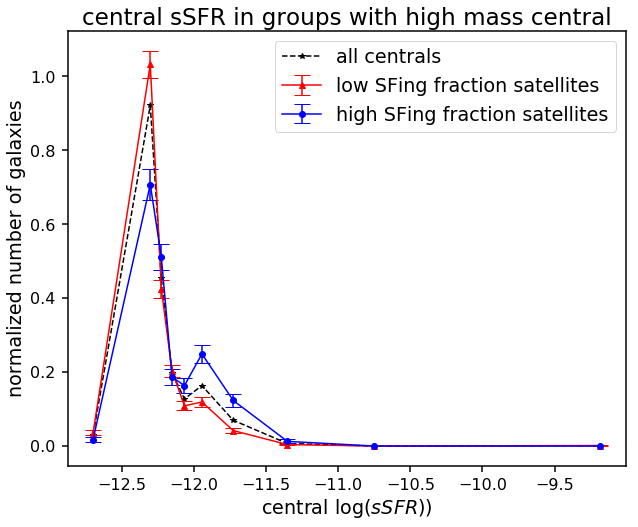

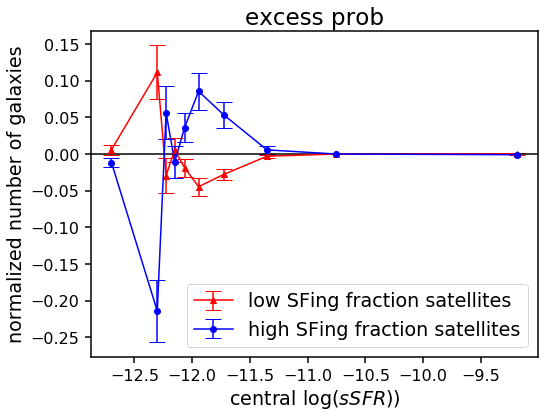

('Low SF central excess probability', 0.07720079202167401)
('high SF central excess probability', 0.018515694961188617)


In [92]:
fig = plt.figure(figsize=(10,8))
plt.style.use(mpl_style.style1)

AG_HM_cent_ssfr = np.concatenate((AG_HM_cent_ssfr_pas_sat, AG_HM_cent_ssfr_act_sat))
bin_edges_HM_init = np.percentile(AG_HM_cent_ssfr, np.linspace(0, 100, 11))

bin_edges_HM = []
combine_inds = []
for b in np.arange(len(bin_edges_HM_init)-1):
    if b in combine_inds:
        bin_edges_HM.append((bin_edges_HM_init[b+1] + bin_edges_HM_init[b])/2)
    elif b-1 not in combine_inds:
        bin_edges_HM.append(bin_edges_HM_init[b])
bin_edges_HM.append(bin_edges_HM_init[-1])

plotpts_HM = []
for i in range(len(bin_edges_HM[:-1])):
    plotpts_HM.append(bin_edges_HM[i] + (bin_edges_HM[i+1]-bin_edges_HM[i])/2)
plotpts_HM = np.array(plotpts_HM)
print('low sf', len(AG_HM_cent_ssfr_pas_sat))
print('high sf', len(AG_HM_cent_ssfr_act_sat))
cent_HM_ssfr_hist, all_bins_HM = np.histogram(AG_HM_cent_ssfr, density=True, bins=10)
cent_HM_ssfr_pas_sat_hist, pas_bins_HM = np.histogram(AG_HM_cent_ssfr_pas_sat, bins=all_bins_HM, density=True)
cent_HM_ssfr_act_sat_hist, act_bins_HM = np.histogram(AG_HM_cent_ssfr_act_sat, bins=all_bins_HM, density=True)

cent_HM_ssfr_hist_unnorm, all_bins_HM = np.histogram(AG_HM_cent_ssfr, density=False, bins=10)
cent_HM_ssfr_pas_sat_hist_unnorm, pas_bins_HM = np.histogram(AG_HM_cent_ssfr_pas_sat, bins=all_bins_HM, density=False)
cent_HM_ssfr_act_sat_hist_unnorm, act_bins_HM = np.histogram(AG_HM_cent_ssfr_act_sat, bins=all_bins_HM, density=False)

D, p_val = ks_2samp(AG_HM_cent_ssfr_pas_sat, AG_HM_cent_ssfr_act_sat)
print('p value of KS test on high star-forming satellite centrals, low star-forming satellite centrals: '+str(p_val))

HM_cent_pas_yerr_unnorm = np.sqrt(cent_HM_ssfr_pas_sat_hist_unnorm)
HM_cent_pas_yerr = (HM_cent_pas_yerr_unnorm/cent_HM_ssfr_pas_sat_hist_unnorm)*cent_HM_ssfr_pas_sat_hist

HM_cent_act_yerr_unnorm = np.sqrt(cent_HM_ssfr_act_sat_hist_unnorm)
HM_cent_act_yerr = (HM_cent_act_yerr_unnorm/cent_HM_ssfr_act_sat_hist_unnorm)*cent_HM_ssfr_act_sat_hist


plt.plot(plotpts_HM, cent_HM_ssfr_hist, c='k', marker='*', label='all centrals',linestyle='--')
plt.errorbar(plotpts_HM, cent_HM_ssfr_pas_sat_hist, HM_cent_pas_yerr, capsize=8, c='r', marker='^', label='low SFing fraction satellites')
plt.errorbar(plotpts_HM, cent_HM_ssfr_act_sat_hist, HM_cent_act_yerr, capsize=8, c='b', marker='o', label='high SFing fraction satellites')
plt.legend()
plt.title('central sSFR in groups with high mass central')
plt.ylabel('normalized number of galaxies')
plt.xlabel('central '+r'$\log (sSFR))$')
#plt.xlim(12.5, 15)
plt.show()

plt.errorbar(plotpts_HM, cent_HM_ssfr_pas_sat_hist - cent_HM_ssfr_hist, HM_cent_pas_yerr, capsize=8, c='r', marker='^', label='low SFing fraction satellites')
plt.errorbar(plotpts_HM, cent_HM_ssfr_act_sat_hist - cent_HM_ssfr_hist, HM_cent_act_yerr, capsize=8, c='b', marker='o', label='high SFing fraction satellites')
plt.legend()
plt.title('excess prob')
plt.ylabel('normalized number of galaxies')
plt.xlabel('central '+r'$\log (sSFR))$')
plt.axhline(0,c='k')
#plt.xlim(12.5, 15)
plt.show()

bins = plotpts_HM
low_sfr_bins = bins[:3]
low_sfr_act = cent_HM_ssfr_act_sat_hist[:3]
low_sfr_pas = cent_HM_ssfr_pas_sat_hist[:3]
excess_low = np.abs(np.trapz(low_sfr_act, low_sfr_bins) - np.trapz(low_sfr_pas, low_sfr_bins))
print('Low SF central excess probability', excess_low)

high_sfr_bins = bins[-4:]
high_sfr_act= cent_HM_ssfr_act_sat_hist[-4:]
high_sfr_pas = cent_HM_ssfr_pas_sat_hist[-4:]
excess_high = np.abs(np.trapz(high_sfr_act, high_sfr_bins) - np.trapz(high_sfr_pas, high_sfr_bins))
print('high SF central excess probability', excess_high)

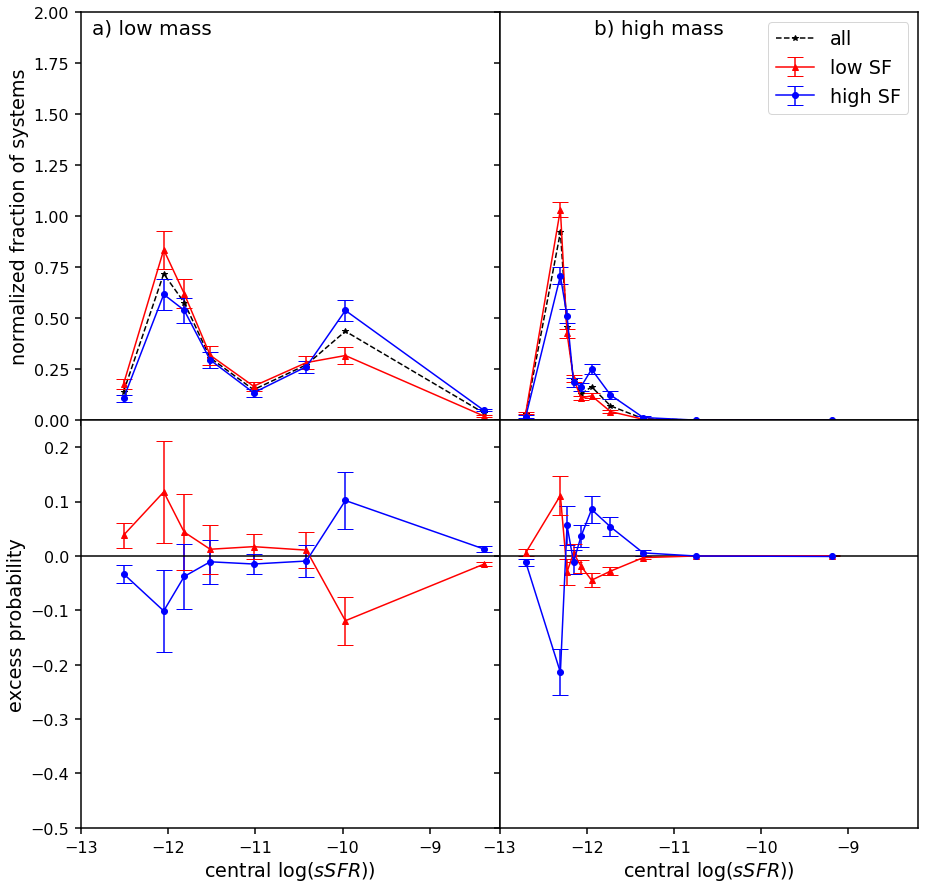

In [109]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharey='row', sharex='col')
f.set_figheight(15)
f.set_figwidth(15)

ax1.plot(plotpts_LM, cent_LM_ssfr_hist, c='k', marker='*', label='all centrals',linestyle='--')
ax1.errorbar(plotpts_LM, cent_LM_ssfr_pas_sat_hist, LM_cent_pas_yerr, capsize=8, c='r', marker='^', label='low SFing fraction satellites')
ax1.errorbar(plotpts_LM, cent_LM_ssfr_act_sat_hist, LM_cent_act_yerr, capsize=8,c='b', marker='o', label='high SFing fraction satellites')
#ax1.legend()
ax1.set_ylabel('normalized fraction of systems')
#ax1.set_xlabel('central '+r'$\log(sSFR)$')
ax1.set_ylim(0, 2)
ax1.set_xlim(-13, -8.2)

ax2.plot(plotpts_HM, cent_HM_ssfr_hist, c='k', marker='*', label='all',linestyle='--')
ax2.errorbar(plotpts_HM, cent_HM_ssfr_pas_sat_hist, HM_cent_pas_yerr, capsize=8, c='r', marker='^', label='low SF')
ax2.errorbar(plotpts_HM, cent_HM_ssfr_act_sat_hist, HM_cent_act_yerr, capsize=8, c='b', marker='o', label='high SF')
#ax2.set_ylabel('fraction')
ax2.set_xlim(-13, -8.2)
ax2.legend()
#ax2.set_xlabel('central '+r'$\log (sSFR))$')

ax3.errorbar(plotpts_LM, cent_LM_ssfr_pas_sat_hist - cent_LM_ssfr_hist, LM_cent_pas_yerr, capsize=8, c='r', marker='^', label='low SF')
ax3.errorbar(plotpts_LM, cent_LM_ssfr_act_sat_hist - cent_LM_ssfr_hist, LM_cent_act_yerr, capsize=8, c='b', marker='o', label='high SF')
ax3.set_ylabel('excess probability')
ax3.axhline(0,c='k')
ax3.set_ylim(-0.5,0.25)
ax3.set_xlabel('central '+r'$\log (sSFR))$')

ax4.errorbar(plotpts_HM, cent_HM_ssfr_pas_sat_hist - cent_HM_ssfr_hist, HM_cent_pas_yerr, capsize=8, c='r', marker='^', label='low SF')
ax4.errorbar(plotpts_HM, cent_HM_ssfr_act_sat_hist - cent_HM_ssfr_hist, HM_cent_act_yerr, capsize=8, c='b', marker='o', label='high SF')
ax4.set_xlabel('central '+r'$\log (sSFR))$')
ax4.axhline(0,c='k')

f.subplots_adjust(wspace=0, hspace=0)

f.text(0.135, 0.86,'a) low mass',fontsize=20)
f.text(0.6, 0.86,'b) high mass',fontsize=20)
plt.savefig('../plots/ssfr_hist_mass.png',dpi=300)

('low pfeat', 1205)
('high pfeat', 475)
p value of KS test on high pfeatures satellites centrals, low pfeatures satellites centrals: 7.881815435993156e-05


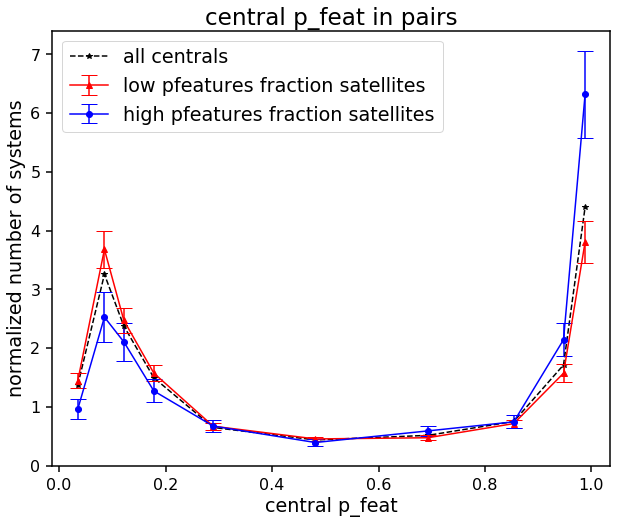

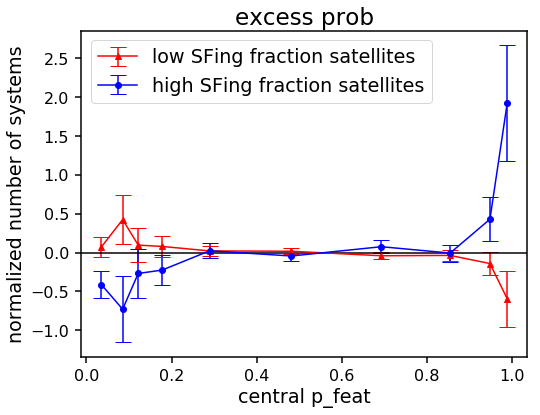

('Smooth central excess probability', 0.06861968629013845)
('Spiral central excess probability', 0.10224576333223301)


In [9]:
fig = plt.figure(figsize=(10,8))
plt.style.use(mpl_style.style1)

PR_cent_pfeat = np.concatenate((PR_cent_pfeat_smooth_sat, PR_cent_pfeat_spiral_sat, PR_cent_pfeat_int_sat))
bin_edges_PR_init = np.percentile(PR_cent_pfeat, np.linspace(0, 100, 11))

bin_edges_PR = []
combine_inds = []
for b in np.arange(len(bin_edges_PR_init)-1):
    if b in combine_inds:
        bin_edges_PR_append((bin_edges_PR_init[b+1] + bin_edges_PR_init[b])/2)
    elif b-1 not in combine_inds:
        bin_edges_PR.append(bin_edges_PR_init[b])
bin_edges_PR.append(bin_edges_PR_init[-1])


plotpts_PR = []
for i in range(len(bin_edges_PR[:-1])):
    plotpts_PR.append(bin_edges_PR[i] + (bin_edges_PR[i+1]-bin_edges_PR[i])/2)
plotpts_PR = np.array(plotpts_PR)
print('low pfeat', len(PR_cent_pfeat_smooth_sat))
print('high pfeat', len(PR_cent_pfeat_spiral_sat))

cent_pfeat_hist_PR, all_bins_PR = np.histogram(PR_cent_pfeat, density=True, bins=bin_edges_PR)
cent_pfeat_smooth_sat_hist_PR,smooth_bins_PR = np.histogram(PR_cent_pfeat_smooth_sat, bins=bin_edges_PR, density=True)
cent_pfeat_spiral_sat_hist_PR,spiral_bins_PR = np.histogram(PR_cent_pfeat_spiral_sat, bins=bin_edges_PR, density=True)
cent_pfeat_int_sat_hist_PR,int_bins_PR = np.histogram(PR_cent_pfeat_int_sat, bins=bin_edges_PR, density=True)

cent_pfeat_hist_PR_unnorm, all_bins_PR = np.histogram(PR_cent_pfeat, density=False, bins=bin_edges_PR)
cent_pfeat_smooth_sat_hist_PR_unnorm,smooth_bins_PR = np.histogram(PR_cent_pfeat_smooth_sat, bins=bin_edges_PR, density=False)
cent_pfeat_spiral_sat_hist_PR_unnorm,spiral_bins_PR = np.histogram(PR_cent_pfeat_spiral_sat, bins=bin_edges_PR, density=False)

D, p_val = ks_2samp(PR_cent_pfeat_smooth_sat, PR_cent_pfeat_spiral_sat)
print('p value of KS test on high pfeatures satellites centrals, low pfeatures satellites centrals: '+str(p_val))

smooth_sat_yerr_PR_unnorm = np.sqrt(cent_pfeat_smooth_sat_hist_PR_unnorm)
smooth_sat_yerr_PR = (smooth_sat_yerr_PR_unnorm/cent_pfeat_smooth_sat_hist_PR_unnorm)*cent_pfeat_smooth_sat_hist_PR

spiral_sat_yerr_PR_unnorm = np.sqrt(cent_pfeat_spiral_sat_hist_PR_unnorm)
spiral_sat_yerr_PR = (spiral_sat_yerr_PR_unnorm/cent_pfeat_spiral_sat_hist_PR_unnorm)*cent_pfeat_spiral_sat_hist_PR

plt.plot(plotpts_PR, cent_pfeat_hist_PR, c='k', marker='*', label='all centrals', linestyle='--')
plt.errorbar(plotpts_PR, cent_pfeat_smooth_sat_hist_PR, smooth_sat_yerr_PR, capsize=8, c='r', marker='^', label='low pfeatures fraction satellites')
plt.errorbar(plotpts_PR, cent_pfeat_spiral_sat_hist_PR, spiral_sat_yerr_PR, capsize=8, c='b', marker='o', label='high pfeatures fraction satellites')
#plt.plot(int_bins[1:] - int_binsize/2, cent_pfeat_int_sat_hist_LG, c='g', marker='>', label='intermediate pfeatures fraction satellites')
plt.legend()
plt.title('central p_feat in pairs')
plt.ylabel('normalized number of systems')
plt.xlabel('central p_feat')
#plt.xlim(-0.01, 1.01)
plt.show()

plt.errorbar(plotpts_PR, cent_pfeat_smooth_sat_hist_PR - cent_pfeat_hist_PR, smooth_sat_yerr_PR, capsize=8, c='r', marker='^', label='low SFing fraction satellites')
plt.errorbar(plotpts_PR, cent_pfeat_spiral_sat_hist_PR - cent_pfeat_hist_PR, spiral_sat_yerr_PR, capsize=8, c='b', marker='o', label='high SFing fraction satellites')
plt.legend()
plt.title('excess prob')
plt.ylabel('normalized number of systems')
plt.xlabel('central p_feat')
plt.axhline(0,c='k')
#plt.xlim(12.5, 15)
plt.show()

bins = plotpts_PR
smooth_bins = bins[:3]
smooth_spiral = cent_pfeat_spiral_sat_hist_PR[:3]
smooth_smooth = cent_pfeat_smooth_sat_hist_PR[:3]
excess_low = np.abs(np.trapz(smooth_spiral, smooth_bins) - np.trapz(smooth_smooth, smooth_bins))
print('Smooth central excess probability', excess_low)
           
spiral_bins = bins[-4:]
spiral_spiral = cent_pfeat_spiral_sat_hist_PR[-4:]
spiral_smooth = cent_pfeat_smooth_sat_hist_PR[-4:]
excess_high = np.abs(np.trapz(spiral_spiral, spiral_bins) - np.trapz(spiral_smooth, spiral_bins))
print('Spiral central excess probability', excess_high)

('low pfeat', 987)
('high pfeat', 303)
p value of KS test on high pfeatures satellites centrals, low pfeatures satellites centrals: 0.0008080592929114029


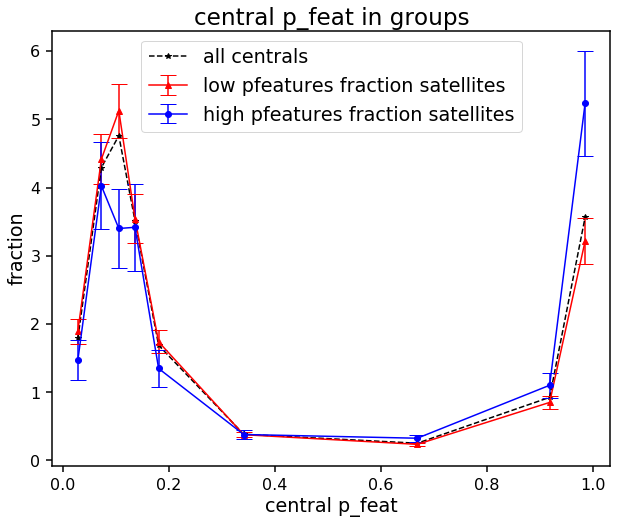

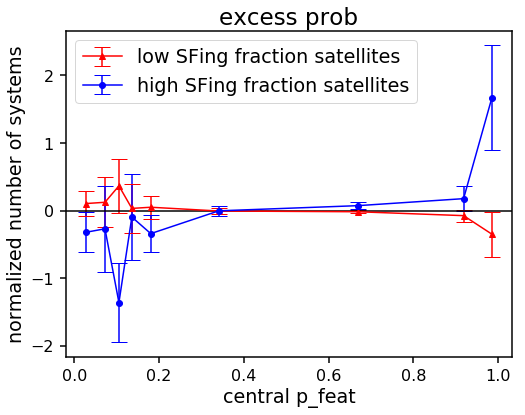

('Smooth central excess probability', 0.05304538745201509)
('Spiral central excess probability', 0.13383072593375406)


In [10]:
fig = plt.figure(figsize=(10,8))
plt.style.use(mpl_style.style1)

LG_cent_pfeat = np.concatenate((LG_cent_pfeat_smooth_sat, LG_cent_pfeat_spiral_sat, LG_cent_pfeat_int_sat))
bin_edges_LG_init = np.percentile(LG_cent_pfeat, np.linspace(0, 100, 11))

bin_edges_LG = []
combine_inds = [2]
for b in np.arange(len(bin_edges_LG_init)-1):
    if b in combine_inds:
        bin_edges_LG.append((bin_edges_LG_init[b+1] + bin_edges_LG_init[b])/2)
    elif b-1 not in combine_inds:
        bin_edges_LG.append(bin_edges_LG_init[b])
bin_edges_LG.append(bin_edges_LG_init[-1])

plotpts_LG = []
for i in range(len(bin_edges_LG[:-1])):
    plotpts_LG.append(bin_edges_LG[i] + (bin_edges_LG[i+1]-bin_edges_LG[i])/2)
plotpts_LG = np.array(plotpts_LG)
print('low pfeat', len(LG_cent_pfeat_smooth_sat))
print('high pfeat', len(LG_cent_pfeat_spiral_sat))
cent_pfeat_hist_LG, all_bins_LG = np.histogram(LG_cent_pfeat, density=True, bins=bin_edges_LG)
cent_pfeat_smooth_sat_hist_LG,smooth_bins_LG = np.histogram(LG_cent_pfeat_smooth_sat, bins=bin_edges_LG, density=True)
cent_pfeat_spiral_sat_hist_LG,spiral_bins_LG = np.histogram(LG_cent_pfeat_spiral_sat, bins=bin_edges_LG, density=True)
cent_pfeat_int_sat_hist_LG,int_bins_LG = np.histogram(LG_cent_pfeat_int_sat, bins=bin_edges_LG, density=True)

cent_pfeat_hist_LG_unnorm, all_bins_LG = np.histogram(LG_cent_pfeat, density=False, bins=bin_edges_LG)
cent_pfeat_smooth_sat_hist_LG_unnorm,smooth_bins_LG = np.histogram(LG_cent_pfeat_smooth_sat, bins=bin_edges_LG, density=False)
cent_pfeat_spiral_sat_hist_LG_unnorm,spiral_bins_LG = np.histogram(LG_cent_pfeat_spiral_sat, bins=bin_edges_LG, density=False)

D, p_val = ks_2samp(LG_cent_pfeat_smooth_sat, LG_cent_pfeat_spiral_sat)
print('p value of KS test on high pfeatures satellites centrals, low pfeatures satellites centrals: '+str(p_val))

smooth_sat_yerr_LG_unnorm = np.sqrt(cent_pfeat_smooth_sat_hist_LG_unnorm)
smooth_sat_yerr_LG = (smooth_sat_yerr_LG_unnorm/cent_pfeat_smooth_sat_hist_LG_unnorm)*cent_pfeat_smooth_sat_hist_LG

spiral_sat_yerr_LG_unnorm = np.sqrt(cent_pfeat_spiral_sat_hist_LG_unnorm)
spiral_sat_yerr_LG = (spiral_sat_yerr_LG_unnorm/cent_pfeat_spiral_sat_hist_LG_unnorm)*cent_pfeat_spiral_sat_hist_LG

plt.plot(plotpts_LG, cent_pfeat_hist_LG, c='k', marker='*', label='all centrals', linestyle='--')
plt.errorbar(plotpts_LG, cent_pfeat_smooth_sat_hist_LG, smooth_sat_yerr_LG, capsize=8, c='r', marker='^', label='low pfeatures fraction satellites')
plt.errorbar(plotpts_LG, cent_pfeat_spiral_sat_hist_LG, spiral_sat_yerr_LG, capsize=8, c='b', marker='o', label='high pfeatures fraction satellites')
#plt.plot(int_bins[1:] - int_binsize/2, cent_pfeat_int_sat_hist_LG, c='g', marker='>', label='intermediate pfeatures fraction satellites')
plt.legend()
plt.title('central p_feat in groups')
plt.ylabel('fraction')
plt.xlabel('central p_feat')
#plt.xlim(-0.01, 1.01)
plt.show()

plt.errorbar(plotpts_LG, cent_pfeat_smooth_sat_hist_LG - cent_pfeat_hist_LG, smooth_sat_yerr_LG, capsize=8, c='r', marker='^', label='low SFing fraction satellites')
plt.errorbar(plotpts_LG, cent_pfeat_spiral_sat_hist_LG - cent_pfeat_hist_LG, spiral_sat_yerr_LG, capsize=8, c='b', marker='o', label='high SFing fraction satellites')
plt.legend()
plt.title('excess prob')
plt.ylabel('normalized number of systems')
plt.xlabel('central p_feat')
plt.axhline(0,c='k')
#plt.xlim(12.5, 15)
plt.show()

bins = plotpts_LG
smooth_bins = bins[:3]
smooth_spiral = cent_pfeat_spiral_sat_hist_LG[:3]
smooth_smooth = cent_pfeat_smooth_sat_hist_LG[:3]
excess_low = np.abs(np.trapz(smooth_spiral, smooth_bins) - np.trapz(smooth_smooth, smooth_bins))
print('Smooth central excess probability', excess_low)
           
spiral_bins = bins[-4:]
spiral_spiral = cent_pfeat_spiral_sat_hist_LG[-4:]
spiral_smooth = cent_pfeat_smooth_sat_hist_LG[-4:]
excess_high = np.abs(np.trapz(spiral_spiral, spiral_bins) - np.trapz(spiral_smooth, spiral_bins))
print('Spiral central excess probability', excess_high)

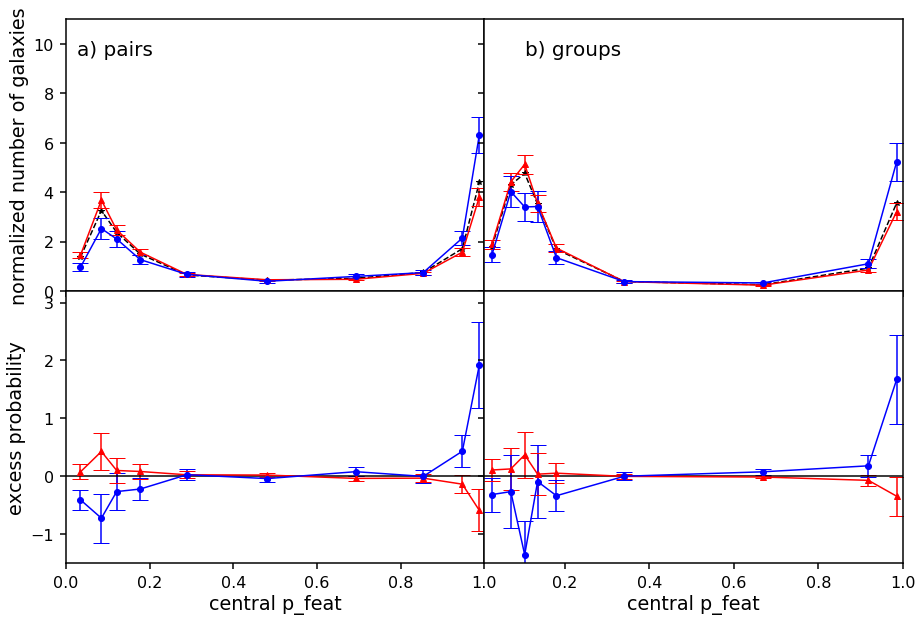

In [11]:
f, ((ax1, ax2), (ax4, ax5)) = plt.subplots(2, 2, sharey='row', sharex='col')
f.set_figheight(10)
f.set_figwidth(15)

ax1.plot(plotpts_PR, cent_pfeat_hist_PR, c='k', marker='*', label='all centrals', linestyle='--')
ax1.errorbar(plotpts_PR, cent_pfeat_smooth_sat_hist_PR, smooth_sat_yerr_PR, capsize=8, c='r', marker='^', label='low pfeatures fraction satellites')
ax1.errorbar(plotpts_PR, cent_pfeat_spiral_sat_hist_PR, spiral_sat_yerr_PR, capsize=8, c='b', marker='o', label='high pfeatures fraction satellites')
#ax1.plot(int_bins2[1:] - int_binsize2/2, cent_pfeat_int_sat_hist, c='g', marker='>', label='intermediate')
ax1.set_ylabel('normalized number of galaxies')
#ax1.set_xlabel('central p_feat')
ax1.set_ylim(0, 11)
ax1.set_xlim(0, 1.)

ax2.plot(plotpts_LG, cent_pfeat_hist_LG, c='k', marker='*', label='all', linestyle='--')
ax2.errorbar(plotpts_LG, cent_pfeat_smooth_sat_hist_LG, smooth_sat_yerr_LG, capsize=8, c='r', marker='^', label='smooth')
ax2.errorbar(plotpts_LG, cent_pfeat_spiral_sat_hist_LG, spiral_sat_yerr_LG, capsize=8, c='b', marker='o', label='featured')
#ax2.plot(int_bins[1:] - int_binsize/2, cent_pfeat_int_sat_hist_LG, c='g', marker='>', label='intermediate')
ax2.set_xlim(0.01, 1)
#ax2.set_xlabel('central p_feat')

ax4.errorbar(plotpts_PR, cent_pfeat_smooth_sat_hist_PR - cent_pfeat_hist_PR, smooth_sat_yerr_PR, capsize=8, c='r', marker='^', label='smooth')
ax4.errorbar(plotpts_PR, cent_pfeat_spiral_sat_hist_PR - cent_pfeat_hist_PR, spiral_sat_yerr_PR, capsize=8, c='b', marker='o', label='featured')
#ax4.plot(int_bins[1:] - int_binsize/2, cent_pfeat_int_sat_hist_LG, c='g', marker='>', label='intermediate')
ax4.axhline(0,c='k')
ax4.set_xlabel('central p_feat')
ax4.set_ylabel('excess probability')
ax4.set_ylim(-1.5, 3.2)

ax5.errorbar(plotpts_LG, cent_pfeat_smooth_sat_hist_LG - cent_pfeat_hist_LG, smooth_sat_yerr_LG, capsize=8, c='r', marker='^', label='smooth')
ax5.errorbar(plotpts_LG, cent_pfeat_spiral_sat_hist_LG - cent_pfeat_hist_LG, spiral_sat_yerr_LG, capsize=8, c='b', marker='o', label='featured')
#ax3.plot(int_bins[1:] - int_binsize/2, cent_pfeat_int_sat_hist_LG, c='g', marker='>', label='intermediate')
ax5.set_xlabel('central p_feat')
ax5.axhline(0,c='k')

f.subplots_adjust(wspace=0, hspace=0)

f.text(0.135, 0.83,'a) pairs',fontsize=20)
f.text(0.55, 0.83,r'b) groups',fontsize=20)


plt.savefig('../plots/pfeat_hist.png',dpi=300)

('low pfeat', 408)
('high pfeat', 176)
p value of KS test on high pfeatures satellites centrals, low pfeatures satellites centrals: 0.00010047129654573023


/homes/jotter/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:838: RuntimeWarning: divide by zero encountered in true_divide
  return n/db/n.sum(), bin_edges
/homes/jotter/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:3250: RuntimeWarning: invalid value encountered in double_scalars
  in cbook.safezip(data, err)]


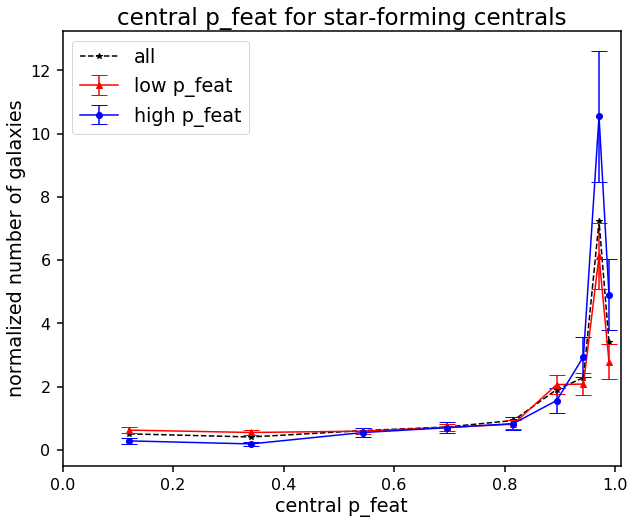

/homes/jotter/.local/lib/python2.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in subtract
/homes/jotter/.local/lib/python2.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in subtract


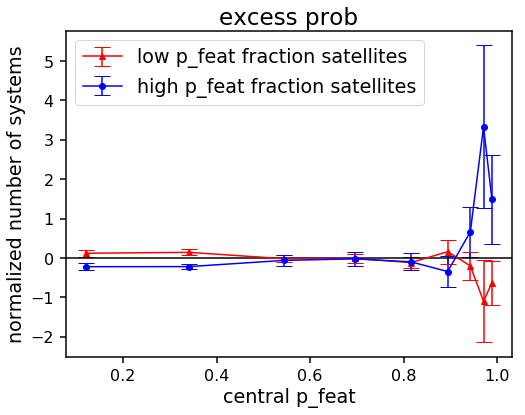

('Smooth central excess probability', 0.0)
('Spiral central excess probability', nan)


/homes/jotter/.local/lib/python2.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in double_scalars


In [12]:
fig = plt.figure(figsize=(10,8))
plt.style.use(mpl_style.style1)

AG_active_cent_pfeat = np.concatenate((AG_active_cent_pfeat_smooth_sat, AG_active_cent_pfeat_spiral_sat, AG_active_cent_pfeat_mixed_sat))
bin_edges_active_init = np.percentile(AG_active_cent_pfeat, np.linspace(0, 100, 11))

bin_edges_active = []
combine_inds = []
for b in np.arange(len(bin_edges_active_init)-1):
    if b in combine_inds:
        bin_edges_active_append((bin_edges_active_init[b+1] + bin_edges_active_init[b])/2)
    elif b-1 not in combine_inds:
        bin_edges_active.append(bin_edges_active_init[b])
bin_edges_active.append(bin_edges_active_init[-1])

plotpts_active = []
for i in range(len(bin_edges_active[:-1])):
    plotpts_active.append(bin_edges_active[i] + (bin_edges_active[i+1]-bin_edges_active[i])/2)
plotpts_active = np.array(plotpts_active)
print('low pfeat', len(AG_active_cent_pfeat_smooth_sat))
print('high pfeat', len(AG_active_cent_pfeat_spiral_sat))

cent_active_pfeat_hist, all_bins = np.histogram(AG_active_cent_pfeat, bins=bin_edges_active, density=True)
cent_active_pfeat_smooth_sat_hist,smooth_bins = np.histogram(AG_active_cent_pfeat_smooth_sat, bins=bin_edges_active, density=True)
cent_active_pfeat_spiral_sat_hist,spiral_bins = np.histogram(AG_active_cent_pfeat_spiral_sat, bins=bin_edges_active, density=True)
cent_active_pfeat_int_sat_hist,int_bins = np.histogram(AG_active_cent_pfeat_mixed_sat, bins=all_bins, density=True)

cent_active_pfeat_hist_unnorm, all_bins = np.histogram(AG_active_cent_pfeat, bins=bin_edges_active, density=False)
cent_active_pfeat_smooth_sat_hist_unnorm,smooth_bins = np.histogram(AG_active_cent_pfeat_smooth_sat, bins=bin_edges_active, density=False)
cent_active_pfeat_spiral_sat_hist_unnorm,spiral_bins = np.histogram(AG_active_cent_pfeat_spiral_sat, bins=bin_edges_active, density=False)

D, p_val = ks_2samp(AG_active_cent_pfeat_smooth_sat, AG_active_cent_pfeat_spiral_sat)
print('p value of KS test on high pfeatures satellites centrals, low pfeatures satellites centrals: '+str(p_val))

smooth_sat_active_yerr_unnorm = np.sqrt(cent_active_pfeat_smooth_sat_hist_unnorm)
smooth_sat_active_yerr = (smooth_sat_active_yerr_unnorm/cent_active_pfeat_smooth_sat_hist_unnorm)*cent_active_pfeat_smooth_sat_hist

spiral_sat_active_yerr_unnorm = np.sqrt(cent_active_pfeat_spiral_sat_hist_unnorm)
spiral_sat_active_yerr = (spiral_sat_active_yerr_unnorm/cent_active_pfeat_spiral_sat_hist_unnorm)*cent_active_pfeat_spiral_sat_hist

plt.plot(plotpts_active, cent_active_pfeat_hist, c='k', marker='*', label='all', linestyle='--')
plt.errorbar(plotpts_active, cent_active_pfeat_smooth_sat_hist, smooth_sat_active_yerr, capsize=8, c='r', marker='^', label='low p_feat')
plt.errorbar(plotpts_active, cent_active_pfeat_spiral_sat_hist, spiral_sat_active_yerr, capsize=8, c='b', marker='o', label='high p_feat')
plt.legend()
plt.title('central p_feat for star-forming centrals')
plt.ylabel('normalized number of galaxies')
plt.xlabel('central p_feat')
plt.xlim(0, 1.01)
plt.show()

plt.errorbar(plotpts_active, cent_active_pfeat_smooth_sat_hist - cent_active_pfeat_hist, smooth_sat_active_yerr, capsize=8, c='r', marker='^', label='low p_feat fraction satellites')
plt.errorbar(plotpts_active, cent_active_pfeat_spiral_sat_hist - cent_active_pfeat_hist, spiral_sat_active_yerr, capsize=8, c='b', marker='o', label='high p_feat fraction satellites')
plt.title('excess prob')
plt.ylabel('normalized number of systems')
plt.xlabel('central p_feat')
plt.axhline(0,c='k')
#plt.xlim(12.5, 15)
plt.legend()
plt.show()

bins = plotpts_active
smooth_bins = bins[:3]
smooth_spiral = cent_active_pfeat_smooth_sat_hist[:3]
smooth_smooth = cent_active_pfeat_smooth_sat_hist[:3]
excess_low = np.abs(np.trapz(smooth_spiral, smooth_bins) - np.trapz(smooth_smooth, smooth_bins))
print('Smooth central excess probability', excess_low)
           
spiral_bins = bins[-4:]
spiral_spiral = cent_active_pfeat_spiral_sat_hist[-4:]
spiral_smooth = cent_active_pfeat_spiral_sat_hist[-4:]
excess_high = np.abs(np.trapz(spiral_spiral, spiral_bins) - np.trapz(spiral_smooth, spiral_bins))
print('Spiral central excess probability', excess_high)

('low pfeat', 1784)
('high pfeat', 602)
p value of KS test on high pfeatures satellites centrals, low pfeatures satellites centrals: 5.800071477745282e-06


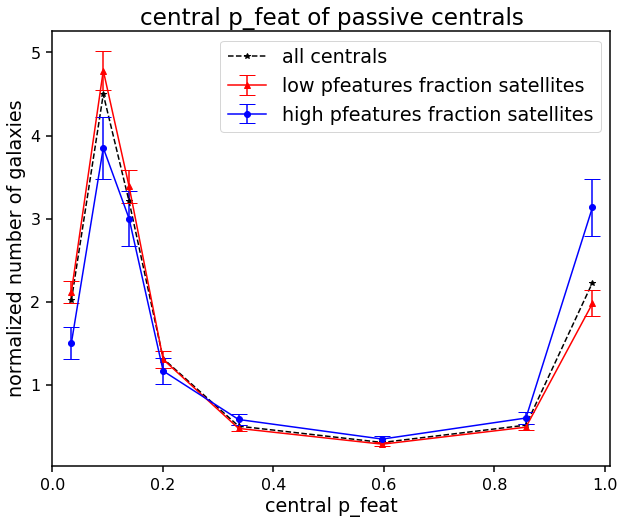

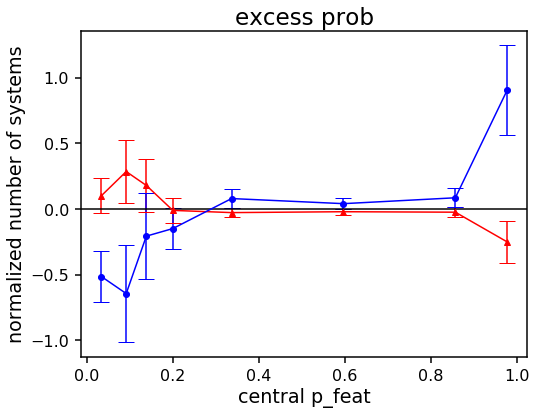

('Smooth central excess probability', 0.07541613739903369)
('Spiral central excess probability', 0.12051590744049723)


In [13]:
fig = plt.figure(figsize=(10,8))
plt.style.use(mpl_style.style1)

AG_passive_cent_pfeat = np.concatenate((AG_passive_cent_pfeat_smooth_sat, AG_passive_cent_pfeat_spiral_sat, AG_passive_cent_pfeat_mixed_sat))
bin_edges_passive_init = np.percentile(AG_passive_cent_pfeat, np.linspace(0, 100, 11))

bin_edges_passive = []
combine_inds = [1,3]
for b in np.arange(len(bin_edges_passive_init)-1):
    if b in combine_inds:
        bin_edges_passive.append((bin_edges_passive_init[b+1] + bin_edges_passive_init[b])/2)
    elif b-1 not in combine_inds:
        bin_edges_passive.append(bin_edges_passive_init[b])
bin_edges_passive.append(bin_edges_passive_init[-1])

plotpts_passive = []
for i in range(len(bin_edges_passive[:-1])):
    plotpts_passive.append(bin_edges_passive[i] + (bin_edges_passive[i+1]-bin_edges_passive[i])/2)
plotpts_passive = np.array(plotpts_passive)
print('low pfeat', len(AG_passive_cent_pfeat_smooth_sat))
print('high pfeat', len(AG_passive_cent_pfeat_spiral_sat))

cent_passive_pfeat_hist, all_bins2 = np.histogram(AG_passive_cent_pfeat, bins=bin_edges_passive, density=True)
cent_passive_pfeat_smooth_sat_hist,smooth_bins2 = np.histogram(AG_passive_cent_pfeat_smooth_sat, bins=bin_edges_passive, density=True)
cent_passive_pfeat_spiral_sat_hist,spiral_bins2 = np.histogram(AG_passive_cent_pfeat_spiral_sat, bins=bin_edges_passive, density=True)
cent_passive_pfeat_int_sat_hist,int_bins2= np.histogram(AG_passive_cent_pfeat_mixed_sat, bins=all_bins2, density=True)

cent_passive_pfeat_hist_unnorm, all_bins2 = np.histogram(AG_passive_cent_pfeat, bins=bin_edges_passive, density=False)
cent_passive_pfeat_smooth_sat_hist_unnorm,smooth_bins2 = np.histogram(AG_passive_cent_pfeat_smooth_sat, bins=bin_edges_passive, density=False)
cent_passive_pfeat_spiral_sat_hist_unnorm,spiral_bins2 = np.histogram(AG_passive_cent_pfeat_spiral_sat, bins=bin_edges_passive, density=False)

D, p_val = ks_2samp(AG_passive_cent_pfeat_smooth_sat, AG_passive_cent_pfeat_spiral_sat)
print('p value of KS test on high pfeatures satellites centrals, low pfeatures satellites centrals: '+str(p_val))

smooth_sat_passive_yerr_unnorm = np.sqrt(cent_passive_pfeat_smooth_sat_hist_unnorm)
smooth_sat_passive_yerr = (smooth_sat_passive_yerr_unnorm/cent_passive_pfeat_smooth_sat_hist_unnorm)*cent_passive_pfeat_smooth_sat_hist

spiral_sat_passive_yerr_unnorm = np.sqrt(cent_passive_pfeat_spiral_sat_hist_unnorm)
spiral_sat_passive_yerr = (spiral_sat_passive_yerr_unnorm/cent_passive_pfeat_spiral_sat_hist_unnorm)*cent_passive_pfeat_spiral_sat_hist

plt.plot(plotpts_passive, cent_passive_pfeat_hist, c='k', marker='*', label='all centrals', linestyle='--')
plt.errorbar(plotpts_passive, cent_passive_pfeat_smooth_sat_hist, smooth_sat_passive_yerr, capsize=8, c='r', marker='^', label='low pfeatures fraction satellites')
plt.errorbar(plotpts_passive, cent_passive_pfeat_spiral_sat_hist, spiral_sat_passive_yerr, capsize=8, c='b', marker='o', label='high pfeatures fraction satellites')
plt.legend()
plt.title('central p_feat of passive centrals')
plt.ylabel('normalized number of galaxies')
plt.xlabel('central p_feat')
plt.xlim(0, 1.01)
plt.show()

plt.errorbar(plotpts_passive, cent_passive_pfeat_smooth_sat_hist - cent_passive_pfeat_hist, smooth_sat_passive_yerr, capsize=8, c='r', marker='^', label='low p_feat fraction satellites')
plt.errorbar(plotpts_passive, cent_passive_pfeat_spiral_sat_hist - cent_passive_pfeat_hist, spiral_sat_passive_yerr, capsize=8, c='b', marker='o', label='high p_feat fraction satellites')
plt.title('excess prob')
plt.ylabel('normalized number of systems')
plt.xlabel('central p_feat')
plt.axhline(0,c='k')
#plt.xlim(12.5, 15)
plt.show()

bins = plotpts_passive
smooth_bins = bins[:3]
smooth_spiral = cent_passive_pfeat_spiral_sat_hist[:3]
smooth_smooth = cent_passive_pfeat_smooth_sat_hist[:3]
excess_low = np.abs(np.trapz(smooth_spiral, smooth_bins) - np.trapz(smooth_smooth, smooth_bins))
print('Smooth central excess probability', excess_low)
           
spiral_bins = bins[-4:]
spiral_spiral = cent_passive_pfeat_spiral_sat_hist[-4:]
spiral_smooth = cent_passive_pfeat_smooth_sat_hist[-4:]
excess_high = np.abs(np.trapz(spiral_spiral, spiral_bins) - np.trapz(spiral_smooth, spiral_bins))
print('Spiral central excess probability', excess_high)

/homes/jotter/.local/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in subtract
/homes/jotter/.local/lib/python2.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in subtract


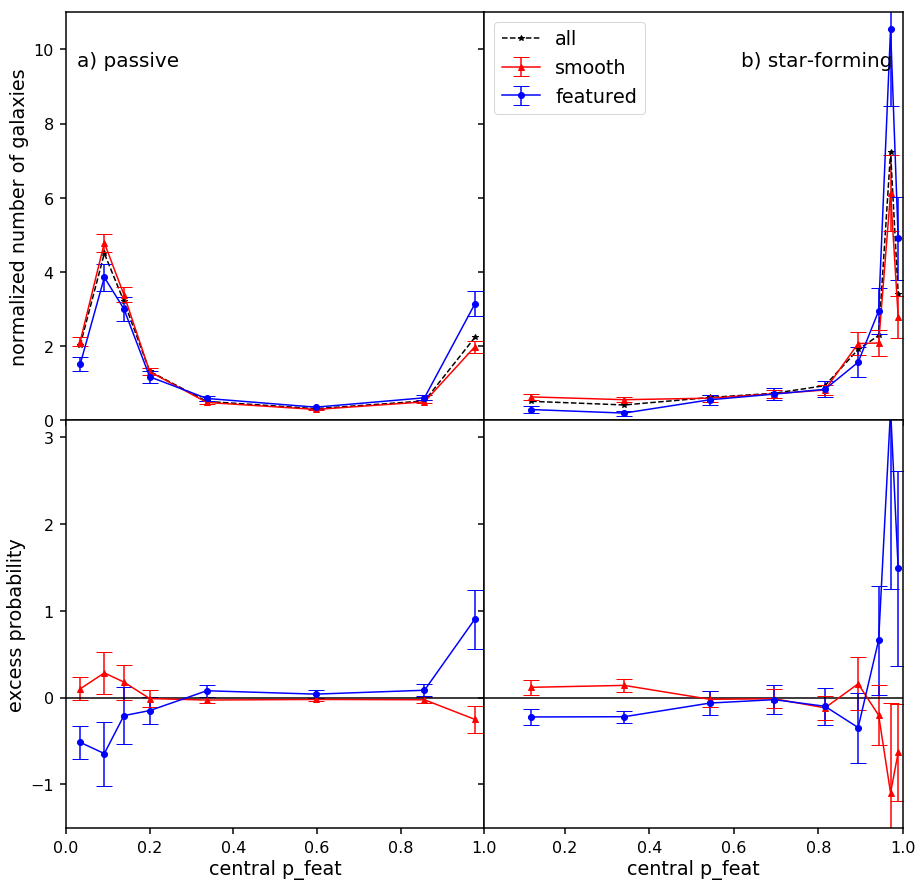

In [15]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharey='row', sharex='col')
f.set_figheight(15)
f.set_figwidth(15)

ax1.plot(plotpts_passive, cent_passive_pfeat_hist, c='k', marker='*', label='all centrals', linestyle='--')
ax1.errorbar(plotpts_passive, cent_passive_pfeat_smooth_sat_hist, smooth_sat_passive_yerr, capsize=8, c='r', marker='^', label='low pfeatures fraction satellites')
ax1.errorbar(plotpts_passive, cent_passive_pfeat_spiral_sat_hist, spiral_sat_passive_yerr, capsize=8, c='b', marker='o', label='high pfeatures fraction satellites')
#ax1.plot(int_bins2[1:] - int_binsize2/2, cent_passive_pfeat_int_sat_hist, c='g', marker='>', label='intermediate')
ax1.set_ylabel('normalized number of galaxies')
ax1.set_ylim(0, 11)
ax1.set_xlim(0, 1)

ax2.plot(plotpts_active, cent_active_pfeat_hist, c='k', marker='*', label='all', linestyle='--')
ax2.errorbar(plotpts_active, cent_active_pfeat_smooth_sat_hist, smooth_sat_active_yerr, capsize=8, c='r', marker='^', label='smooth')
ax2.errorbar(plotpts_active, cent_active_pfeat_spiral_sat_hist, spiral_sat_active_yerr, capsize=8, c='b', marker='o', label='featured')
#ax2.plot(int_bins[1:] - int_binsize/2, cent_active_pfeat_int_sat_hist, c='g', marker='>', label='intermediate')
#ax2.set_ylabel('fraction')
ax2.legend(loc='upper left')
ax2.set_xlim(0.01, 1)
#ax2.set_xlabel('central p_feat')

ax3.errorbar(plotpts_passive, cent_passive_pfeat_smooth_sat_hist - cent_passive_pfeat_hist, smooth_sat_passive_yerr, capsize=8, c='r', marker='^', label='low pfeatures fraction satellites')
ax3.errorbar(plotpts_passive, cent_passive_pfeat_spiral_sat_hist - cent_passive_pfeat_hist, spiral_sat_passive_yerr, capsize=8, c='b', marker='o', label='high pfeatures fraction satellites')
#ax1.plot(int_bins2[1:] - int_binsize2/2, cent_passive_pfeat_int_sat_hist, c='g', marker='>', label='intermediate')
ax3.set_ylabel('excess probability')
ax3.set_xlabel('central p_feat')
ax3.set_ylim(-1.5, 3.2)
ax3.axhline(0,c='k')

ax4.errorbar(plotpts_active, cent_active_pfeat_smooth_sat_hist - cent_active_pfeat_hist, smooth_sat_active_yerr, capsize=8, c='r', marker='^', label='low pfeatures fraction satellites')
ax4.errorbar(plotpts_active, cent_active_pfeat_spiral_sat_hist - cent_active_pfeat_hist, spiral_sat_active_yerr, capsize=8, c='b', marker='o', label='high pfeatures fraction satellites')
#ax1.plot(int_bins2[1:] - int_binsize2/2, cent_passive_pfeat_int_sat_hist, c='g', marker='>', label='intermediate')
ax4.set_xlabel('central p_feat')
#ax3.set_ylim(0, 1.5)
ax4.axhline(0,c='k')

f.subplots_adjust(wspace=0,hspace=0)

f.text(0.135, 0.83,'a) passive',fontsize=20)
f.text(0.75, 0.83,'b) star-forming',fontsize=20)

plt.savefig('../plots/pfeat_cent_ssfr.png',dpi=300)

In [31]:
fig = plt.figure(figsize=(10,8))
plt.style.use(mpl_style.style1)

cent_avg_pfeat_smooth_sat_hist_LG,b = np.histogram(LG_cent_avg_pfeat_smooth, bins=25)
cent_avg_pfeat_spiral_sat_hist_LG,bin_edges = np.histogram(LG_cent_avg_pfeat_spiral, bins=25)
cent_avg_pfeat_int_sat_hist_LG,bin_edges = np.histogram(LG_cent_avg_pfeat_int, bins=25)
cent_avg_pfeat_hist_LG = cent_avg_pfeat_smooth_sat_hist_LG + cent_avg_pfeat_spiral_sat_hist_LG + cent_avg_pfeat_int_sat_hist_LG

D, p_val = ks_2samp(cent_avg_pfeat_spiral_sat_hist_LG, cent_avg_pfeat_smooth_sat_hist_LG)
print('before norm p value of KS test on high pfeatures satellites centrals, low pfeatures satellites centrals: '+str(p_val))

cent_avg_pfeat_smooth_sat_hist_LG = cent_avg_pfeat_smooth_sat_hist_LG/np.sum(cent_avg_pfeat_smooth_sat_hist_LG)
cent_avg_pfeat_spiral_sat_hist_LG = cent_avg_pfeat_spiral_sat_hist_LG/np.sum(cent_avg_pfeat_spiral_sat_hist_LG)
cent_avg_pfeat_int_sat_hist_LG = cent_avg_pfeat_int_sat_hist_LG/np.sum(cent_avg_pfeat_int_sat_hist_LG)
cent_avg_pfeat_hist_LG = cent_avg_pfeat_hist_LG/np.sum(cent_avg_pfeat_hist_LG)

D, p_val = ks_2samp(cent_avg_pfeat_spiral_sat_hist_LG, cent_avg_pfeat_smooth_sat_hist_LG)
print('p value of KS test on high pfeatures satellites centrals, low pfeatures satellites centrals: '+str(p_val))

bin_edges_adj = bin_edges[1:]

plt.plot(bin_edges_adj, cent_avg_pfeat_hist_LG, c='k', marker='*', label='all centrals', linestyle='--')
plt.plot(bin_edges_adj, cent_avg_pfeat_smooth_sat_hist_LG, c='r', marker='^', label='smooth avg satllites')
plt.plot(bin_edges_adj, cent_avg_pfeat_spiral_sat_hist_LG, c='b', marker='o', label='featured avg satellites')
plt.plot(bin_edges_adj, cent_avg_pfeat_int_sat_hist_LG, c='g', marker='>', label='intermediate avg satellites')
plt.legend()
plt.title('central p_feat in groups with > 2 satellites (avg)')
plt.ylabel('normalized number of galaxies')
plt.xlabel('central p_feat')
plt.xlim(0, 1.01)

plt.close()

before norm p value of KS test on high pfeatures satellites centrals, low pfeatures satellites centrals: 1.0
p value of KS test on high pfeatures satellites centrals, low pfeatures satellites centrals: 1.0


/homes/ashill/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in true_divide
/homes/ashill/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in true_divide
/homes/ashill/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in true_divide
/homes/ashill/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in true_divide


In [32]:
fig = plt.figure(figsize=(10,8))
plt.style.use(mpl_style.style1)

cent_avg_pfeat_smooth_sat_hist_AG,b = np.histogram(AG_cent_avg_pfeat_smooth, bins=25)
cent_avg_pfeat_spiral_sat_hist_AG,bin_edges = np.histogram(AG_cent_avg_pfeat_spiral, bins=25)
cent_avg_pfeat_int_sat_hist_AG,bin_edges = np.histogram(AG_cent_avg_pfeat_int, bins=25)
cent_avg_pfeat_hist_AG = cent_avg_pfeat_smooth_sat_hist_AG + cent_avg_pfeat_spiral_sat_hist_AG + cent_avg_pfeat_int_sat_hist_AG

D, p_val = ks_2samp(cent_avg_pfeat_spiral_sat_hist_LG, cent_avg_pfeat_smooth_sat_hist_LG)
print('before norm p value of KS test on high pfeatures satellites centrals, low pfeatures satellites centrals: '+str(p_val))

cent_avg_pfeat_smooth_sat_hist_AG = cent_avg_pfeat_smooth_sat_hist_AG/np.sum(cent_avg_pfeat_smooth_sat_hist_AG)
cent_avg_pfeat_spiral_sat_hist_AG = cent_avg_pfeat_spiral_sat_hist_AG/np.sum(cent_avg_pfeat_spiral_sat_hist_AG)
cent_avg_pfeat_int_sat_hist_AG = cent_avg_pfeat_int_sat_hist_AG/np.sum(cent_avg_pfeat_int_sat_hist_AG)
cent_avg_pfeat_hist_AG = cent_avg_pfeat_hist_AG/np.sum(cent_avg_pfeat_hist_AG)

D, p_val = ks_2samp(cent_avg_pfeat_spiral_sat_hist_AG, cent_avg_pfeat_smooth_sat_hist_AG)
print('p value of KS test on high pfeatures satellites centrals, low pfeatures satellites centrals: '+str(p_val))

bin_edges_adj = bin_edges[1:]

plt.plot(bin_edges_adj, cent_avg_pfeat_hist_AG, c='k', marker='*', label='all centrals', linestyle='--')
plt.plot(bin_edges_adj, cent_avg_pfeat_smooth_sat_hist_AG, c='r', marker='^', label='smooth avg satllites')
plt.plot(bin_edges_adj, cent_avg_pfeat_spiral_sat_hist_AG, c='b', marker='o', label='featured avg satellites')
plt.plot(bin_edges_adj, cent_avg_pfeat_int_sat_hist_AG, c='g', marker='>', label='intermediate avg satellites')
plt.legend()
plt.title('central p_feat in groups with > 2 satellites (avg)')
plt.ylabel('normalized number of galaxies')
plt.xlabel('central p_feat')
plt.xlim(0, 1.01)

plt.close()

before norm p value of KS test on high pfeatures satellites centrals, low pfeatures satellites centrals: 1.0
p value of KS test on high pfeatures satellites centrals, low pfeatures satellites centrals: 1.0


/homes/ashill/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in true_divide
/homes/ashill/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in true_divide
/homes/ashill/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in true_divide
/homes/ashill/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in true_divide


In [33]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_figheight(5)
f.set_figwidth(15)

#ax1 = fig.add_subplot(221)
ax1.plot(bin_edges_adj, cent_avg_pfeat_hist_AG, c='k', marker='*', label='all centrals', linestyle='--')
ax1.plot(bin_edges_adj, cent_avg_pfeat_smooth_sat_hist_AG, c='r', marker='^', label='low pfeatures fraction satellites')
ax1.plot(bin_edges_adj, cent_avg_pfeat_spiral_sat_hist_AG, c='b', marker='o', label='high pfeatures fraction satellites')
ax1.plot(bin_edges_adj, cent_avg_pfeat_int_sat_hist_AG, c='g', marker='>', label='intermediate')
ax1.set_ylabel('normalized number of galaxies')
ax1.set_xlabel('central p_feat')
#ax1.set_ylim(0, 1.5)
#ax1.set_xlim(-15.5, -22.75)

#ax2 = fig.add_subplot(222)
ax2.plot(bin_edges_adj, cent_avg_pfeat_hist_LG, c='k', marker='*', label='all', linestyle='--')
ax2.plot(bin_edges_adj, cent_avg_pfeat_smooth_sat_hist_LG, c='r', marker='^', label='smooth')
ax2.plot(bin_edges_adj, cent_avg_pfeat_spiral_sat_hist_LG, c='b', marker='o', label='featured')
ax2.plot(bin_edges_adj, cent_avg_pfeat_int_sat_hist_LG, c='g', marker='>', label='intermediate')
#ax2.set_ylabel('fraction')
plt.legend()
ax2.set_xlabel('central p_feat')

f.subplots_adjust(wspace=0)

f.text(0.135, 0.83,'a)',fontsize=20)
f.text(0.53, 0.83,'b)',fontsize=20)
plt.close()
#plt.savefig('../plots/pfeat_hist.png',dpi=300)

In [82]:
plt.style.use(mpl_style.style1)
plt.figure(figsize=(10,20))
hist, xedges, yedges = np.histogram2d(frac_sat_sfing,cent_ssfr, 10)
print(len(cent_ssfr))
plt.imshow(hist, extent=[np.min(cent_ssfr), np.max(cent_ssfr),np.min(frac_sat_sfing), np.max(frac_sat_sfing)])
#plt.scatter(cent_ssfr, frac_sat_sfing)
plt.xlabel('central ssfr')
plt.ylabel('fraction of star-forming satellites')
plt.ylim(0,1)
plt.xlim(-12.5,-8.3)
plt.close()

3305


In [80]:
plt.style.use(mpl_style.style1)

hist, xedges, yedges = np.histogram2d(cent_ssfr, sat_ssfr, 50)
plt.imshow(hist, extent=[np.min(cent_ssfr), np.max(cent_ssfr),np.min(sat_ssfr), np.max(sat_ssfr)])
#plt.scatter(cent_ssfr, sat_ssfr)
plt.xlabel('central ssfr')
plt.ylabel('mean ssfr of satellites')
plt.ylim(-12.8,-9.2)
plt.xlim(-12.5,-8.3)
plt.close()

In [81]:
plt.style.use(mpl_style.style1)

hist, xedges, yedges = np.histogram2d(frac_sat_spiral, cent_pspiral, 15)

plt.imshow(hist, extent=[np.min(cent_pspiral), np.max(cent_pspiral),np.min(frac_sat_spiral), np.max(frac_sat_spiral)])

#plt.scatter(cent_pspiral, frac_sat_spiral)
plt.xlabel('central pfeatures')
plt.ylabel('fraction of high pfeatures satellites')
plt.close()

In [79]:
plt.style.use(mpl_style.style1)

hist, xedges, yedges = np.histogram2d(cent_pspiral, sat_pspiral_edit, 25)

plt.imshow(hist, extent=[np.min(cent_pspiral), np.max(cent_pspiral),np.min(sat_pspiral_edit), np.max(sat_pspiral_edit)])

#plt.scatter(cent_pspiral, sat_pspiral_edit)
plt.xlabel('central pfeatures')
plt.ylabel('mean pfeatures of satellites')
plt.close()

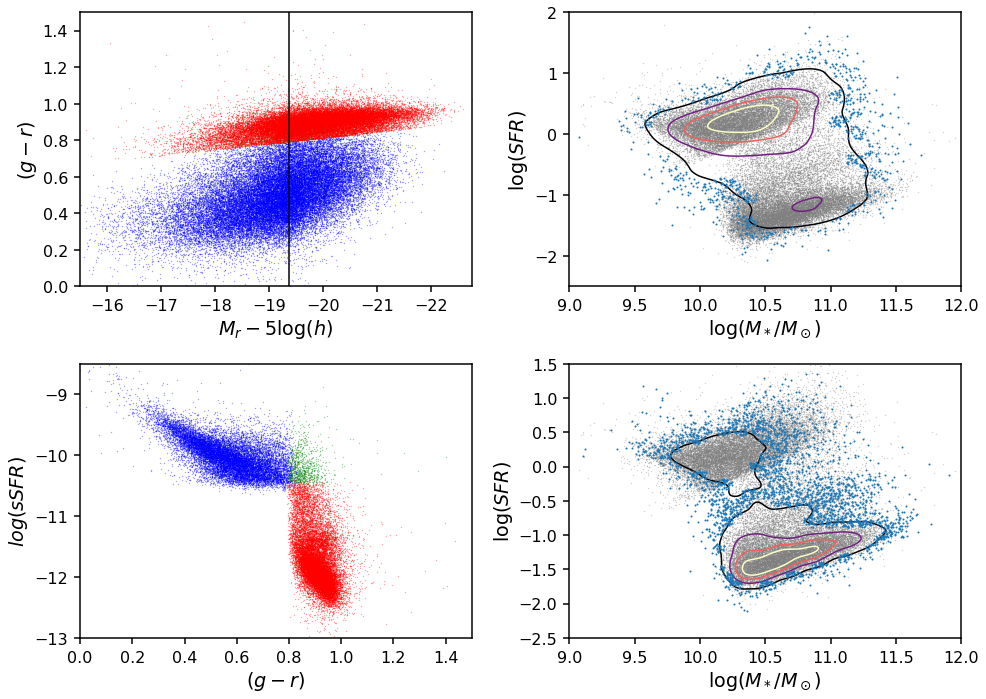

'\nplt.imshow(spiral_hist)\nplt.show()\nplt.imshow(smooth_hist)\nplt.show()'

In [28]:
fig = plt.figure(figsize=(14,10))

colors_uncut = [[x[0] for x in bluact_color_all], [x[0] for x in redact_color_all], [x[0] for x in redpas_color_all]] #this method gets the first element of the tuples
mrs_uncut = [[x[0] for x in bluact_mr_all], [x[0] for x in redact_mr_all], [x[0] for x in redpas_mr_all]]
#sfrs_uncut = [[x[0] for x in bluact_sfr_all], [x[0] for x in redact_sfr_all], [x[0] for x in redpas_sfr_all]]
#masses_uncut = [[x[0] for x in bluact_mass_all], [x[0] for x in redact_mass_all], [x[0] for x in redpas_mass_all]]

colors = [[x[0] for x in bluact_color], [x[0] for x in redact_color], [x[0] for x in redpas_color]] #this method gets the first element of the tuples
mrs = [[x[0] for x in bluact_mr], [x[0] for x in redact_mr], [x[0] for x in redpas_mr]]
sfrs = [[x[0] for x in bluact_sfr], [x[0] for x in redact_sfr], [x[0] for x in redpas_sfr]]
masses = [[x[0] for x in bluact_mass], [x[0] for x in redact_mass], [x[0] for x in redpas_mass]]

spiral_ind_all = [x[0] for x in spiral_ind]
smooth_ind_all = [x[0] for x in smooth_ind]

spiral_mass = mass[spiral_ind_all]
smooth_mass = mass[smooth_ind_all]
spiral_sfr = spiral_mass+ssfr[spiral_ind_all]
smooth_sfr = smooth_mass+ssfr[smooth_ind_all]

nonzero_spiral_ind = np.where(spiral_mass > 0)
nonzero_spiral_mass = spiral_mass[nonzero_spiral_ind]
nonzero_spiral_sfr = spiral_sfr[nonzero_spiral_ind]
nonzero_smooth_ind = np.where(smooth_mass > 0)
nonzero_smooth_mass = smooth_mass[nonzero_smooth_ind]
nonzero_smooth_sfr = smooth_sfr[nonzero_smooth_ind]

plot_color = ['b', 'g', 'r']
plt.style.use(mpl_style.style1)
#top left plot
ax1 = fig.add_subplot(221)
for i in np.arange(3):
    ax1.scatter(mrs_uncut[i], colors_uncut[i], color = plot_color[i], s=0.1, alpha=0.5)
plt.axvline(adj_M_limit,c='k')
ax1.set_ylabel(r'$(g-r)$')
ax1.set_xlabel(r'$M_r - 5\log(h)$')
ax1.set_ylim(0, 1.5)
ax1.set_xlim(-15.5, -22.75)

#top right plot
ax2 = fig.add_subplot(222)
for i in np.arange(3):
    ax2.scatter(masses[i], np.array(masses[i])+np.array(sfrs[i]), color = 'gray', s=0.1, alpha=0.5)
#ax2.scatter(spiral_mass, spiral_sfr, color='blue')
hs.hex_contour(nonzero_spiral_mass, nonzero_spiral_sfr, min_cnt = 50, levels=4,hkwargs={'gridsize':20}) #'extent':[9,12,3,-2.5],
ax2.set_xlabel(r'$\log(M_*/M_\odot)$') 
ax2.set_ylabel(r'$\log(SFR)$')
ax2.set_ylim(-2.5, 2)
#ax2.set_xscale('log')
ax2.set_xlim(9, 12)

#bottom left plot
ax3 = fig.add_subplot(223)
for i in np.arange(3):
    ax3.scatter(colors[i], sfrs[i], color = plot_color[i], s=0.1, alpha=0.5)
ax3.set_ylabel(r'$log(sSFR)$')
ax3.set_xlabel(r'$(g-r)$')
ax3.set_ylim(-13, -8.5)
ax3.set_xlim(0,1.5)

#bottom right plot
ax4 = fig.add_subplot(224)
for i in np.arange(3):
    ax4.scatter(masses[i], np.array(masses[i])+np.array(sfrs[i]), color = 'gray', s=0.1, alpha=0.5)
#ax4.scatter(smooth_mass, smooth_sfr, color='red')
hs.hex_contour(smooth_mass, smooth_sfr, levels = 4, min_cnt = 50)
ax4.set_xlabel(r'$\log(M_*/M_\odot)$')
ax4.set_ylabel(r'$\log(SFR)$')
ax4.set_ylim(-2.5, 1.5)
#ax4.set_xscale('log')
ax4.set_xlim(9, 12)

plt.tight_layout()
plt.savefig('../plots/sample_plot.png', dpi=300)
plt.show()
'''
plt.imshow(spiral_hist)
plt.show()
plt.imshow(smooth_hist)
plt.show()'''